<a href="https://colab.research.google.com/github/peruvianox/WEAV-AI/blob/main/WEAV_Proof_of_Concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive & Import Libraries

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import re
import joblib
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import signal
from scipy import interpolate
from google.colab import output
from scipy.stats.mstats import pearsonr
from scipy.signal import find_peaks, resample
import time 
import imageio
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
# from pygifsicle import optimize
DataFolder = '/content/drive/My Drive/SpeedFpClampData/Data'
os.chdir(DataFolder)
subjects = [x for x in os.listdir(DataFolder)]

In [3]:
def FlipY(DF, DIM):
  # Augmentation function
  df = DF.copy() # make a copy of the input DF to not change that array
  TRC = df.iloc[:,5:].to_numpy()
  S = np.shape(TRC)
  newTRC = TRC.reshape((S[0], DIM, -1), order='F')
  nS = newTRC.shape
  y = list(range(2, nS[2], 3)) # get y indicies to flip
  newTRC[:,:,y] = -newTRC[:,:,y] 
  df.iloc[:,5:] = newTRC.reshape(S, order='F')
  # df.head()
  return df

# Extract & Transform Data

In [ ]:
# Define Active Trial Analysis Function
def TrlMetAnalysis(TrlStr, t, VO2_kg, VO2, VCO2, Mkr):
    today = dt.datetime.today()
    
    # add start and end times
    StartStr = 'start' + TrlStr
    EndStr = 'end' + TrlStr
        
    # pull start and end times of trial
    StartInd = Mkr.index(StartStr)
    EndInd = Mkr.index(EndStr)
    
    # define VO2 during trial
    TrialVO2_kg = VO2_kg[StartInd:EndInd]
    TrialVO2 = VO2[StartInd:EndInd]
    TrialVCO2 = VCO2[StartInd:EndInd]
    TrialW = (np.multiply(np.divide(TrialVO2, 1000), 16.58) + 
              np.multiply(np.divide(TrialVCO2, 1000), 4.51)) * 1000 / 60 

    # create start and end times as datetimes
    StartTime = dt.datetime.combine(today, t[StartInd])
    
    # convert to seconds
    TrlSec = []
    for i in t[StartInd:EndInd]:
        TrlTime = dt.datetime.combine(today, i)
        ts = TrlTime - StartTime
        TrlSec.append(ts.total_seconds())
    
    # find final 2 min of trial
    Final2Min = [x for x in TrlSec if x >= 180]
    Final2MinInd = TrlSec.index(Final2Min[0])
    
    # average VO2 over final 2 min 
    TrialWAvg = np.mean(TrialW[Final2MinInd:EndInd])

    # filter metabolic signal to continuous measure
    f = interpolate.interp1d(TrlSec, TrialW)
    xnew = np.arange(0,max(TrlSec))
    FiltW = f(xnew)

    # trim to final 2 minutes
    FiltW = FiltW[180:300]
    xnew = xnew[180:300]

    VO2Data = {
        'Trial Name' : TrlStr,
        'Time Values' : TrlSec,
        'W Avg' : TrialWAvg,
        'All W Data' : TrialW,
        'Filt W Data' : FiltW, 
        'Filt Time' : xnew
        }
    
    return VO2Data

In [ ]:
def Mkrs2Keypts(TrcData):
# data reduction function
# reduce motion capture data to joint center positions for:
# hip, knee, ankle, toes, shoulder, elbow, and wrist

    # KNEES
    if 'R.MKnee.X' in trcData.columns:
        RKnee = np.mean(np.dstack((TrcData.filter(like='R.Knee.'), 
                                TrcData.filter(like='R.MKnee.'))), 
                        axis=2).squeeze()
    else: 
        RKnee = TrcData.filter(like='R.Knee.')
    RKneeCols = ['RKneeX','RKneeY','RKneeZ']

    if 'L.MKnee.X' in TrcData.columns:
        LKnee = np.mean(np.dstack((TrcData.filter(like='L.Knee.'), 
                                TrcData.filter(like='L.MKnee.'))), 
                        axis=2).squeeze()
    else: 
        LKnee = TrcData.filter(like='L.Knee.')
    LKneeCols = ['LKneeX','LKneeY','LKneeZ']

    # ANKLES
    if 'R.MAnkle.X' in trcData.columns:
        RAnkle = np.mean(np.dstack((TrcData.filter(like='R.Ankle.'), 
                                TrcData.filter(like='R.MAnkle.'))), 
                        axis=2).squeeze()
    else: 
        RAnkle = TrcData.filter(like='R.Ankle.')
    RAnkleCols = ['RAnkleX','RAnkleY','RAnkleZ']

    if 'L.MAnkle.X' in TrcData.columns:
        LAnkle = np.mean(np.dstack((TrcData.filter(like='L.Ankle.'), 
                                TrcData.filter(like='L.MAnkle.'))), 
                        axis=2).squeeze()
    else: 
        LAnkle = TrcData.filter(like='L.Ankle.')
    LAnkleCols = ['LAnkleX','LAnkleY','LAnkleZ']

    # ELBOWS
    TrcData.columns = TrcData.columns.str.replace('Elbot', 'Elbow')
    if 'R.MedElbow.X' in trcData.columns:
        RElbow = np.mean(np.dstack((TrcData.filter(like='R.LatElbow.'), 
                                TrcData.filter(like='R.MedElbow.'))), 
                        axis=2).squeeze()
    else: 
        RElbow = TrcData.filter(like='R.LatElbow.')
    RElbowCols = ['RElbowX','RElbowY','RElbowZ']

    if 'L.MedElbow.X' in TrcData.columns:
        LElbow = np.mean(np.dstack((TrcData.filter(like='L.LatElbow.'), 
                                TrcData.filter(like='L.MedElbow.'))), 
                        axis=2).squeeze()
    else: 
        LElbow = TrcData.filter(like='L.LatElbow.')
    LElbowCols = ['LElbowX','LElbowY','LElbowZ']

    # WRISTS
    if 'R.MedWrist.X' in trcData.columns:
        RWrist = np.mean(np.dstack((TrcData.filter(like='R.LatWrist.'), 
                                TrcData.filter(like='R.MedWrist.'))), 
                        axis=2).squeeze()
    elif 'R.Wrist1.X' in trcData.columns:
        RWrist = np.mean(np.dstack((TrcData.filter(like='R.Wrist1.'), 
                                TrcData.filter(like='R.Wrist5.'))), 
                        axis=2).squeeze() 
    else: 
        RWrist = TrcData.filter(like='R.LatWrist.')
    RWristCols = ['RWristX','RWristY','RWristZ']

    if 'L.MedWrist.X' in TrcData.columns:
        LWrist = np.mean(np.dstack((TrcData.filter(like='L.LatWrist.'), 
                                TrcData.filter(like='L.MedWrist.'))), 
                        axis=2).squeeze()
    elif 'L.Wrist1.X' in trcData.columns:
        LWrist = np.mean(np.dstack((TrcData.filter(like='L.Wrist1.'), 
                                TrcData.filter(like='L.Wrist5.'))), 
                        axis=2).squeeze() 
    else: 
        LWrist = TrcData.filter(like='L.LatWrist.')
    LWristCols = ['LWristX','LWristY','LWristZ']

    # TOES
    RToe = np.mean(np.dstack((TrcData.filter(like='R.MT1.'), 
                            TrcData.filter(like='R.MT5.'))), 
                    axis=2).squeeze()
    RToeCols = ['RToeX','RToeY','RToeZ']
    LToe = np.mean(np.dstack((TrcData.filter(like='L.MT1.'), 
                            TrcData.filter(like='L.MT5.'))), 
                    axis=2).squeeze()
    LToeCols = ['LToeX','LToeY','LToeZ']
    Reduced = pd.DataFrame(data=np.hstack((RKnee, LKnee, RAnkle, LAnkle, RToe, LToe,
                    RElbow, LElbow, RWrist, LWrist)),
                columns=np.hstack((RKneeCols, LKneeCols, RAnkleCols, LAnkleCols, RToeCols, LToeCols,
                    RElbowCols, LElbowCols, RWristCols, LWristCols)))

    DF = pd.concat([TrcData.filter(like='.HJC.'), TrcData.filter(like='.Acr.'), Reduced], axis=1)
    c = DF.columns.tolist()
    c.sort()
    return DF[c]

In [ ]:
ReProcess = 0
if ReProcess is 1:
  Subj = {}
  nbins = 2

  # make column names for dataFrame
  c = ['Subj','Cond','Bin', 'MetCost']
  df = pd.DataFrame(columns=c)

  # full model
  trcCols = []
  for i in range(int(14*3*120/nbins*50)):
    trcCols.append('TRC'+str(i))
  trc_full = pd.DataFrame(columns=trcCols)

  # + torso model
  trcCols = []
  for i in range(int(10*3*120/nbins*50)):
    trcCols.append('TRC'+str(i))
  trc_torso = pd.DataFrame(columns=trcCols)

  # + foot model
  trcCols = []
  for i in range(int(8*3*120/nbins*50)):
    trcCols.append('TRC'+str(i))
  trc_foot = pd.DataFrame(columns=trcCols)

  # base model
  trcCols = []
  for i in range(int(6*3*120/nbins*50)):
    trcCols.append('TRC'+str(i))
  trc_base = pd.DataFrame(columns=trcCols)

  # sham model
  trcCols = []
  for i in range(int(6*3*120/nbins*50)):
    trcCols.append('TRC'+str(i))
  trc_sham = pd.DataFrame(columns=trcCols)

  for f in subjects:
    if re.search('.mat|.csv|.ipy|.gif', f):
      continue
    if f not in Subj:
      Subj[f] = {}
    print('Processing Subject: ' + f)
    SubjFolder = DataFolder + '/' + f
    os.chdir(SubjFolder)

    # get REE metabolic data
    reeFile = [x for x in os.listdir(SubjFolder) if 'REE' in x]
    # get body mass from ree file
    Subj[f]['Mass'] = float(pd.read_excel(reeFile[0], usecols='B', skiprows=[0,1,2,3,4], nrows=1).to_numpy().squeeze())
    RMR = pd.read_excel(reeFile[0])
    
    # pull VO2 and time data
    VO2_kg = RMR.loc[2:len(RMR),'VO2/Kg']
    VO2 = RMR.loc[2:len(RMR),'VO2']
    VCO2 = RMR.loc[2:len(RMR),'VCO2']
    t = RMR.loc[2:len(RMR),'t'].values
    W = (VO2 /1000 * 16.5 + VCO2 /1000 * 4.51) * 1000 / 60 

    # # find rows after 3 min
    T = []
    c = 0
    for i in t:
      c = c + 1
      if i.minute >=3:
        T.append(c)  
            
    # calculate average REE
    AvgW = np.mean(W[T])     
    Subj[f]['RMR W Avg'] = AvgW 
    # normalize to body mass
    print(f + ' Average RMR = '+ str(round(AvgW / Subj[f]['Mass'],3)) + '  mL/kg/min')

    # get met data trials
    metFile = [x for x in os.listdir(SubjFolder) if 'CPET' in x]
    metDF = pd.read_excel(metFile[0])
    
    # pull VO2 and time data
    VO2_kg = metDF.loc[2:len(metDF),'VO2/Kg']
    VO2 = metDF.loc[2:len(metDF),'VO2']
    VCO2 = metDF.loc[2:len(metDF),'VCO2']
    t = metDF.loc[2:len(metDF),'t'].values.tolist()
    Mkr = metDF.loc[2:len(metDF),'Marker'].values.tolist()

    # process VO2 data
    conditions = ['S_M20','S_M10','S_Norm','S_P10','S_P20', 
                'F_M20','F_M10','F_Norm','F_P10','F_P20', 
                'C_M20','C_P20']
    mc = {}
    for c in conditions: 
      d = TrlMetAnalysis(c, t, VO2_kg, VO2, VCO2, Mkr)
      # calculate net watts / kg
      mc[c] = np.array( (d['Filt W Data']-Subj[f]['RMR W Avg']) / Subj[f]['Mass'] )
      # plt.plot(VO2data[c][0], VO2data[c][1])

      # ensure there are 120 values for binning later on
      L = np.size(mc[c])
      if L is not 120:
        z = np.empty(120-L)
        z[:] = np.nan
        mc[c] = np.hstack((mc[c], z))

    # save TRC data
    OsimFolder = DataFolder + '/' + f +'/OpenSim'
    os.chdir(OsimFolder)
    trcData = {}
    trcFiles = [x for x in os.listdir(OsimFolder) if '.trc' in x]
    for t in trcFiles:
      if not re.search('HJC|Static', t):

        # save condition 
        Cond = re.sub('Trimmed_|.trc|_1|_2|_4|_OpenSim', '', t)

        # load TRC file with trajectories
        trcDF = pd.read_csv(t, sep='\t',header=3, nrows=1) # get headers
        trcData = pd.read_csv(t, sep='\t',header=4) # get columns

        # get column names
        Cols = list(trcDF.columns)
        c = Cols[0:2]
        del Cols[0:2]
        NewCols = []
        counter = 0
        for x in range(len(Cols)): 
            if 'Unnamed' not in Cols[x]: 
                NewCols.append(Cols[x] + '.X')
            elif 'Unnamed' not in Cols[x-1]:
                NewCols.append(Cols[x-1] + '.Y')
            elif 'Unnamed' not in Cols[x-2]:
                NewCols.append(Cols[x-2] + '.Z')
            elif 'Unnamed' not in Cols[x-3]:
                NewCols.append('ToDel')

        # rename columns to reflect X,Y,Z locations of trajectories
        N = []
        for x in c + NewCols:
            N.append(re.sub(' ','',x))
        if '.X' in N[-1]:
            n = re.sub('.X','.Y',N[-1])
            N.append(n)
        if '.Y' in N[-1]:
            n = re.sub('.Y','.Z',N[-1])
            N.append(n)

        # add column names to df with data
        s = trcData.shape
        while trcData.shape[1] > len(N):
            N.append('Unnamed')

        trcData.columns = N

        # drop unnecessary rows and columns
        p = 'Hand|Bicep|Offset|T10|Notch|SH1|SH2|SH3|SH4|TH1|TH2|TH3|TH4|ToDel|Frame|Time|Unnamed|ASIS|PSIS|S2|Heel|Toe'
        ToDrop = [x for x in trcData.columns if re.search(p, x)]
        trcData = trcData.drop(columns=ToDrop)
        RedTrcData = Mkrs2Keypts(trcData)
        S = RedTrcData.shape

        # normalize trc data
        x = list(range(0, int(S[1]), 3))
        y = list(range(1, int(S[1]), 3))
        z = list(range(2, int(S[1]), 3))
        downFac = 2 # downsample factor
        trcD = signal.resample_poly(RedTrcData, 1, downFac) # downsample
        d = (trcD - np.mean(trcD)) / np.std(trcD) # normalize by subtracting the mean and dividing by standard dev
        d = np.zeros(trcD.shape)
        d[:,x] = (trcD[:,x] - np.mean(trcD[:,x])) / np.std(trcD[:,x]) # normalize by subtracting the mean and dividing by standard dev along each dimension
        d[:,y] = (trcD[:,y] - np.mean(trcD[:,y])) / np.std(trcD[:,y])
        d[:,z] = (trcD[:,z] - np.mean(trcD[:,z])) / np.std(trcD[:,z])
        trcN = pd.DataFrame(data=d, columns=RedTrcData.columns)

        # trim to torso model
        p = 'Elbow|Wrist'
        ToDrop = [x for x in trcN.columns if re.search(p, x)]
        trcN_torso = trcN.drop(columns=ToDrop)

        # trim to foot model
        p = 'Acr'
        ToDrop = [x for x in trcN_torso.columns if re.search(p, x)]
        trcN_foot = trcN_torso.drop(columns=ToDrop)

        # trim to base model
        p = 'Toe'
        ToDrop = [x for x in trcN_foot.columns if re.search(p, x)]
        trcN_base = trcN_foot.drop(columns=ToDrop)

        # trim to base model
        p = 'Toe|Ankle|Knee|HJC'
        ToDrop = [x for x in trcN.columns if re.search(p, x)]
        trcN_sham = trcN.drop(columns=ToDrop)

        # split trc data
        if len(trcN) == 6000:
            TRC = np.split(trcN.iloc[0:,:], nbins)
            TRC_torso = np.split(trcN_torso.iloc[0:,:], nbins)
            TRC_foot = np.split(trcN_foot.iloc[0:,:], nbins)
            TRC_base = np.split(trcN_base.iloc[0:,:], nbins)
            TRC_sham = np.split(trcN_sham.iloc[0:,:], nbins)
        elif len(trcN) == 6001: 
            TRC = np.split(trcN.iloc[1:,:], nbins)
            TRC_torso = np.split(trcN_torso.iloc[1:,:], nbins)
            TRC_foot = np.split(trcN_foot.iloc[1:,:], nbins)
            TRC_base = np.split(trcN_base.iloc[1:,:], nbins)
            TRC_sham = np.split(trcN_sham.iloc[1:,:], nbins)

        # split metabolic data into bins
        MC = np.nanmean(np.array_split(mc[Cond], nbins), axis=1)

        # loop through bins and save dataFrames
        for i in range(nbins):
            df.loc[len(df.index)] = [ f, Cond, i, MC[i] ]
            trc_full.loc[len(trc_full.index)] = TRC[i].round(5).to_numpy().flatten('F').tolist()
            trc_torso.loc[len(trc_torso.index)] = TRC_torso[i].round(5).to_numpy().flatten('F').tolist()
            trc_foot.loc[len(trc_foot.index)] = TRC_foot[i].round(5).to_numpy().flatten('F').tolist()
            trc_base.loc[len(trc_base.index)] = TRC_base[i].round(5).to_numpy().flatten('F').tolist()
            trc_sham.loc[len(trc_sham.index)] = TRC_sham[i].round(5).to_numpy().flatten('F').tolist()

        print('Saved Trial: ' + Cond)

  
  # get column names for Full condition
  Keypoints = ['RSHO', 'RHIP', 'RANK', 'RELB', 'RKNEE', 'RTOE', 'RWRI', 
  'LSHO', 'LHIP', 'LANK', 'LELB', 'LKNEE', 'LTOE', 'LWRI']
  N = np.repeat(Keypoints, 3)
  AddCoord = ['x','y','z']
  for i in [0, 1, 2]:
    for j in np.arange(0, len(N), 3):
      N[j + i] = N[j + i] + AddCoord[i] 
  if nbins == 8:
    Sec = 15
  elif nbins == 6:
    Sec = 20
  elif nbins == 4:
    Sec = 30
  elif nbins == 2:
    Sec = 60
  Meta = ['Subj','Cond','Bin','MetCost']
  DIM = Sec*50
  Full_columns = Meta + np.repeat(N, DIM).tolist()

  # combine and save dataFrame
  os.chdir('/content/drive/My Drive/SpeedFpClampData')
  DF_Full = pd.concat([df, trc_full], axis=1)
  DF_Full.columns = Full_columns
  DF_Full.to_csv('MetCostTRCData_' + str(nbins) + '.csv')
  DF_Torso = pd.concat([df, trc_torso], axis=1)
  DF_Torso.to_csv('MetCostTRCData_torso_' + str(nbins) + '.csv')
  DF_Foot = pd.concat([df, trc_foot], axis=1)
  DF_Foot.to_csv('MetCostTRCData_foot_' + str(nbins) + '.csv')
  DF_Base = pd.concat([df, trc_base], axis=1)
  DF_Base.to_csv('MetCostTRCData_base_' + str(nbins) + '.csv')
  DF_Sham = pd.concat([df, trc_sham], axis=1)
  DF_Sham.to_csv('MetCostTRCData_sham_' + str(nbins) + '.csv')

<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-23-48d4d3e33f0b>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ReProcess is 1:
<ipython-input-23-48d4d3e33f0b>:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if L is not 120:


Processing Subject: 014
014 Average RMR = 1.488  mL/kg/min
Saved Trial: C_M20
Saved Trial: C_P20
Saved Trial: F_M10
Saved Trial: F_M20
Saved Trial: F_Norm
Saved Trial: F_P10
Saved Trial: F_P20
Saved Trial: S_M10
Saved Trial: S_M20
Saved Trial: S_Norm
Saved Trial: S_P10
Saved Trial: S_P20
Processing Subject: 011
011 Average RMR = 1.318  mL/kg/min
Saved Trial: C_M20
Saved Trial: C_P20
Saved Trial: F_M10
Saved Trial: F_M20
Saved Trial: F_Norm
Saved Trial: F_P10
Saved Trial: F_P20
Saved Trial: S_M10
Saved Trial: S_M20
Saved Trial: S_Norm
Saved Trial: S_P10
Saved Trial: S_P20
Processing Subject: 012
012 Average RMR = 1.294  mL/kg/min
Saved Trial: C_M20
Saved Trial: C_P20
Saved Trial: F_M10
Saved Trial: F_M20
Saved Trial: F_Norm
Saved Trial: F_P10
Saved Trial: F_P20
Saved Trial: S_M10
Saved Trial: S_M20
Saved Trial: S_Norm
Saved Trial: S_P10
Saved Trial: S_P20
Processing Subject: 013
013 Average RMR = 1.54  mL/kg/min
Saved Trial: C_M20
Saved Trial: C_P20
Saved Trial: F_M10
Saved Trial: F_M20

In [ ]:
# Keypoints = ['RSHO', 'RHIP', 'RANK', 'RELB', 'RKNEE', 'RTOE', 'RWRI', 
# 'LSHO', 'LHIP', 'LANK', 'LELB', 'LKNEE', 'LTOE', 'LWRI']
# N = np.repeat(Keypoints, 3)
# AddCoord = ['x','y','z']
# for i in [0, 1, 2]:
#   for j in np.arange(0, len(N), 3):
#     N[j + i] = N[j + i] + AddCoord[i] 
# if nbins == 8:
#   Sec = 15
# elif nbins == 6:
#   Sec = 20
# elif nbins == 4:
#   Sec = 30
# elif nbins == 2:
#   Sec = 60
# Meta = ['Subj','Cond','Bin','MetCost']
# DIM = Sec*50
# Full_columns = Meta + np.repeat(N, DIM).tolist()

# # combine and save dataFrame
# os.chdir('/content/drive/My Drive/SpeedFpClampData')
# DF_Full = pd.concat([df, trc_full], axis=1)
# DF_Full.columns = Full_columns
# DF_Full.to_csv('MetCostTRCData_' + str(nbins) + '.csv')
# DF_Torso = pd.concat([df, trc_torso], axis=1)
# DF_Torso.to_csv('MetCostTRCData_torso_' + str(nbins) + '.csv')
# DF_Foot = pd.concat([df, trc_foot], axis=1)
# DF_Foot.to_csv('MetCostTRCData_foot_' + str(nbins) + '.csv')
# DF_Base = pd.concat([df, trc_base], axis=1)
# DF_Base.to_csv('MetCostTRCData_base_' + str(nbins) + '.csv')
# DF_Sham = pd.concat([df, trc_sham], axis=1)
# DF_Sham.to_csv('MetCostTRCData_sham_' + str(nbins) + '.csv')

In [ ]:
raise StopIteration

## Load Subject Data

In [ ]:
# load data
os.chdir('/content/drive/My Drive/SpeedFpClampData')
# 8 bins, 15 seconds each 
DF_Full_8 = pd.read_csv('MetCostTRCData_8.csv')
DF_Full_8.head()

In this dataset, we have a few metadata variables, including subject #, walking condition, bin #, and the associated metabolic cost for that bin. Following these metadata variables, we have the keypoint trajectories (TRC) in 31500 columns, split by 3D coordinates, 14 body point locations, at 50 hz, for 15 seconds in each bin (3 * 14 * 50 * 15 = 31500).

## Visualize Input Data
Showing the walking data is challenging becasue it contains so many datapoints (31500 points for every row)

Thus I will show a "snapshot" of each subject for one trial at one bin. The dimensions of these plots are noramlized to each participant (by body size), thus I removed the axis labels to keep it clear. 

The titles for each subplot show the subject, condition, metabolic cost, and time. Thus "2_S_Norm_1_3.83 Time 0.0 s" refers to subject 2, walking condition S_Norm_1, metabolic cost of 3.83, and time point of 0.0s.  

In [ ]:
DF = DF_Full_8
# select a subset of the data (Bin = 1, Condition = S_Norm_1)
BinMatch = [i for i, x in enumerate(DF['Bin']) if x == 1]
CondMatch = [i for i, x in enumerate(DF['Cond']) if x == 'S_Norm']
match = set(BinMatch) & set(CondMatch) # get intersection of matched bins & conditions for all subjects (20)

# Visualize Dataset
fig = plt.figure(figsize=(20,20))
for i, r in enumerate(match):
  ax = fig.add_subplot(4,5,i+1, projection='3d')

  TRC = DF.iloc[r,5:]
  S = str(DF['Subj'].iloc[r])
  C = str(DF['Cond'].iloc[r])
  B = str(DF['Bin'].iloc[r])
  MC = str(round(DF['MetCost'].iloc[r], 2))
  name_str = (S, C, B, MC)
  gif_name = '_'.join(name_str)

  d = len(TRC) / 750
  A = np.reshape(TRC.to_list(), (750, int(d)), order='F')
  x = list(range(0, int(d), 3))
  y = list(range(1, int(d), 3))
  z = list(range(2, int(d), 3))

  MS = 6
  t = 0 # first frame
  ax.plot(A[t,x], A[t,z], A[t,y], '.k', alpha=1, markersize = MS) 
  ax.set_title(gif_name + ' Time ' + str(round(t/50, 1)) + ' s')
  ax.set_xlim3d(min(np.min(A, axis=0)), max(np.max(A, axis=0)))
  ax.set_ylim3d(min(np.min(A, axis=0)), max(np.max(A, axis=0)))
  ax.set_zlim3d(min(np.min(A, axis=0)), max(np.max(A, axis=0)))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_zticklabels([])
  plt.savefig('/content/drive/My Drive/SpeedFpClampData/Figures/InputRange.png')

## Visualize Output Data
These are the associated metabolic costs for each "bin" (time period) of walking motion. We report outcomes across 10 walking trials.   

In [ ]:
import seaborn as sb
plt.figure(figsize=(10, 6))
sb.histplot(data=DF, x='MetCost', hue='Cond', element='poly')
plt.title('Range of Walking Metabolic Costs Across Conditions')
plt.xlabel('Metabolic Cost (W/kg)')
plt.savefig('/content/drive/My Drive/SpeedFpClampData/Figures/OutputRange.png')

## Augment data
Flip medial-lateral axis to make a symmetrical copy

In [ ]:
def PlotKeypoints(DF, Subj, Cond, Bin, ax):

  # select a subset of the data (Bin = 1, Condition = S_Norm)
  SubjMatch = [i for i, x in enumerate(DF['Subj']) if x == Subj]
  CondMatch = [i for i, x in enumerate(DF['Cond']) if x == Cond]
  BinMatch = [i for i, x in enumerate(DF['Bin']) if x == Bin]
  match = set(SubjMatch) & set(BinMatch) & set(CondMatch) # get intersection of matched subjects, bins, & conditions 

  # Visualize Dataset
  if ax == 0:
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111, projection='3d')
  for i, r in enumerate(match):
    

    TRC = DF.iloc[r,5:]
    d = len(TRC) / 750
    A = np.reshape(TRC.to_list(), (750, int(d)), order='F')
    x = list(range(0, int(d), 3))
    y = list(range(1, int(d), 3))
    z = list(range(2, int(d), 3))

    MS = 6
    t = 0 # first frame
    ax.plot(A[t,x], A[t,z], A[t,y], '.k', alpha=1, markersize = MS) 
    ax.set_title(gif_name + ' Time ' + str(round(t/50, 1)) + ' s')
    ax.set_xlim3d(min(np.min(A, axis=0)), max(np.max(A, axis=0)))
    ax.set_ylim3d(min(np.min(A, axis=0)), max(np.max(A, axis=0)))
    ax.set_zlim3d(min(np.min(A, axis=0)), max(np.max(A, axis=0)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    ax.view_init(20, 0)
    # plt.show()


In [ ]:
def FlipY(DF, DIM):
  # Augmentation function
  df = DF.copy() # make a copy of the input DF to not change that array
  TRC = df.iloc[:,5:].to_numpy()
  S = np.shape(TRC)
  newTRC = TRC.reshape((S[0], DIM, -1), order='F')
  nS = newTRC.shape
  y = list(range(2, nS[2], 3)) # get y indicies to flip
  newTRC[:,:,y] = -newTRC[:,:,y] 
  df.iloc[:,5:] = newTRC.reshape(S, order='F')
  # df.head()
  return df

In [ ]:
# Augment Datase
ReAugment = 0
if ReAugment == 1: 
  FlipDF = FlipY(DF_Full_8, 15*50)
  Aug = pd.concat([DF_Full_8, FlipDF], axis=0)

  # plot augmentation
  fig = plt.figure(figsize=(16,8))
  ax1 = plt.subplot(121, projection='3d')
  ax2 = plt.subplot(122, projection='3d')

  PlotKeypoints(DF_Full_8, 2, 'F_Norm', 1, ax1)
  PlotKeypoints(FlipDF, 2, 'F_Norm', 1, ax2)

  ax1.set_title('Original')
  ax2.set_title('Augmented (Flipped)')
  plt.savefig('/content/drive/My Drive/SpeedFpClampData/Figures/Augmentation.png')

  Aug.dropna()
  del FlipDF, DF

## Use PCA to find primary features of movement in Full dataset

In [ ]:
from sklearn.decomposition import PCA
X = DF_Full_8.iloc[:,5:]
pca = PCA(0.95) # get top components of X that explain 95% of the variance
# pca = PCA(n_components=20)
pca.fit(X)
# plot a scree plot
components = len(pca.explained_variance_ratio_)
# if components is None else components
print(components)
plt.plot(range(1,components+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

# print top components
components_ = pca.fit_transform(X)
pca_components = abs(pca.components_)
ColComp = []
for row in range(pca_components.shape[0]):
# get the indices of the top 2 values in each row
  temp = np.argpartition(-(pca_components[row]), 1)
  # sort the indices in descending order
  indices = temp[np.argsort((-pca_components[row])[temp])][:1]
  # print the top 2 feature names
  # print(f'Component {row}: {X.columns[indices].to_list()}')
  ColComp.append(X.columns[indices][0])

print(ColComp)

In [ ]:
# show times and categories that most explain variance
len(ColComp)
ColList= list(DF_Full_8.columns[5:])
Empty = np.zeros((1, len(ColList)))
for c in ColComp:
  Empty[0, ColList.index(c)] = 1

# reshape column vector
plt.figure(figsize=(16, 10))
HtMap = Empty.reshape((750, -1), order='F').T

ColNames = np.array(ColList).reshape((750,-1), order='F')
ColNames = ColNames[0,:].tolist()
ColNames[12:15] = ['RKNEEx', 'RKNEEy', 'RKNEEz'] # change some names in colnames
ColNames[33:36] = ['LKNEEx', 'LKNEEy', 'LKNEEz']

import seaborn as sb
import matplotlib.colors as Color
sb.heatmap(HtMap, cbar = False, yticklabels = ColNames, cmap = sb.color_palette('rocket_r'))
plt.xlabel('Frame #')
plt.ylabel('Keypoint')
plt.savefig('/content/drive/My Drive/SpeedFpClampData/Figures/PCATimeFeatures.png' )

In [ ]:
Hist = np.sum(HtMap, axis=1)
plt.figure(figsize=(10,10))
plt.bar(np.arange(len(Hist)), Hist)
plt.xticks(np.arange(len(ColNames)), labels=ColNames, rotation=90)
plt.ylabel('Count')
plt.xlabel('Keypoint')
plt.savefig('/content/drive/My Drive/SpeedFpClampData/Figures/PCAMainFeatures.png' )

In [ ]:
# determine column names
A = DF_Full_8.iloc[0, 5:].to_numpy().reshape((750, -1), order='F')
x = list(range(0, int(d), 3))
y = list(range(1, int(d), 3))
z = list(range(2, int(d), 3))
MS = 6
t = 0 # first frame

plt.figure(figsize=(10,10))
plt.plot(A[t, z[0]], A[t, y[0]], 'o', label='0')
plt.plot(A[t, z[1]], A[t, y[1]], 'o', label='RHIP')
plt.plot(A[t, z[2]], A[t, y[2]], 'o', label='RANK')
plt.plot(A[t, z[3]], A[t, y[3]], 'o', label='3')
plt.plot(A[t, z[4]], A[t, y[4]], 'o', label='4')
plt.plot(A[t, z[5]], A[t, y[5]], 'o', label='5')
plt.plot(A[t, z[6]], A[t, y[6]], 'o', label='6')
plt.plot(A[t, z[7]], A[t, y[7]], 'o', label='7')
plt.plot(A[t, z[8]], A[t, y[8]], 'o', label='8')
plt.plot(A[t, z[9]], A[t, y[9]], 'o', label='9')
plt.plot(A[t, z[10]], A[t, y[10]], 'o', label='10')
plt.plot(A[t, z[11]], A[t, y[11]], 'o', label='11')
plt.plot(A[t, z[12]], A[t, y[12]], 'o', label='12')
plt.plot(A[t, z[13]], A[t, y[13]], 'o', label='13')
plt.text(A[t, z[0]], A[t, y[0]], 'RSHO')
plt.text(A[t, z[1]], A[t, y[1]], 'RHIP')
plt.text(A[t, z[2]], A[t, y[2]], 'RANK')
plt.text(A[t, z[3]], A[t, y[3]], 'RELB')
plt.text(A[t, z[4]], A[t, y[4]], 'RKNEE')
plt.text(A[t, z[5]], A[t, y[5]], 'RTOE')
plt.text(A[t, z[6]], A[t, y[6]], 'RWRI')
plt.text(A[t, z[7]], A[t, y[7]], 'LSHO')
plt.text(A[t, z[8]], A[t, y[8]], 'LHIP')
plt.text(A[t, z[9]], A[t, y[9]], 'LANK')
plt.text(A[t, z[10]], A[t, y[10]], 'LELB')
plt.text(A[t, z[11]], A[t, y[11]], 'LKNEE')
plt.text(A[t, z[12]], A[t, y[12]], 'LTOE')
plt.text(A[t, z[13]], A[t, y[13]], 'LWRI')
plt.axis('equal')
plt.savefig('/content/drive/My Drive/SpeedFpClampData/Figures/NormalizedKeypoints.png')

# Determine Effect of Measurement Duration

## 8 bin analysis


In [4]:
# 8 bins, 15 seconds each 
os.chdir('/content/drive/My Drive/SpeedFpClampData')
DF_Full_8 = pd.read_csv('MetCostTRCData_8.csv') # load full 8 dataset
DIM = 15*50 # reshape dimension
FlipDF = FlipY(DF_Full_8, DIM) # augment dataset
Aug = pd.concat([DF_Full_8, FlipDF], axis=0)
AugShape = Aug.shape

In [5]:
# parse steps for avg & std
ColList= list(DF_Full_8.columns[5:])
ColNames = np.array(ColList).reshape((750,-1), order='F')
ColNames = ColNames[0,:].tolist()
ColNames[12:15] = ['RKNEEx', 'RKNEEy', 'RKNEEz'] # change some names in colnames
ColNames[33:36] = ['LKNEEx', 'LKNEEy', 'LKNEEz']
ColNameAvg = [t + '_Avg' for t in ColNames]
ColNameStd = [t + '_Std' for t in ColNames]
AvgDF8 = pd.DataFrame(columns=[np.repeat([ColNameAvg + ColNameStd], 100)])
MetaDF = Aug.iloc[:,:5]

ReParse = 0
if ReParse == 1:
  # use right toe anterior-posterior location to identify strides
  from scipy.signal import find_peaks, resample
  for x in range(len(Aug)):
    Sub = Aug.iloc[x,5:].to_numpy().reshape((750, -1), order='F') # load subject data
    Rti = ColNames.index('RTOEx') # get toe X position
    pks, props = find_peaks(Sub[:,Rti]) # find peaks to split at those indicies

    Rsteps = np.ndarray((100, Sub.shape[1], len(pks)-1)) 
    for s in range(len(pks)-1): # average data across steps
      step = Sub[pks[s]:pks[s+1], :]
      Rsteps[:,:,s] = resample(step, 100, axis=0)

    SubAvg = Rsteps.mean(axis=2)
    SubStd = Rsteps.std(axis=2)
    AvgDF8.loc[len(AvgDF8),:] = np.concatenate((SubAvg.flatten(), SubStd.flatten()))

  AvgDF8.to_csv('AvgDF8.csv') # save parsed steps
  del Rsteps, 
else: 
  AvgDF8 = pd.read_csv('AvgDF8.csv') # load parsed steps

Avg8 = {}     # create dictionaries to save data
Full8 = {}
AvgStd8 = {}
MAE8 = {}
MAEstd8 = {}
del FlipDF, DF_Full_8
ReTrain = 0

In [10]:
# Implement Avg + Std dataset
AugAvgStd = pd.concat([MetaDF.reset_index(), AvgDF8.reset_index(drop=True)], axis=1, ignore_index=True)
AugAvgStd = AugAvgStd.dropna()

kf = KFold(n_splits=5)
SubjInds = np.arange(1,21)
AvgStd8['MLP'] = []
AvgStd8['SVR'] = []
MAE8['MLPAvgStd'] = []
MAEstd8['MLPAvgStd'] = []
MAE8['SVRAvgStd'] = []
MAEstd8['SVRAvgStd'] = []
for j, (train_index, test_index) in enumerate(kf.split(SubjInds)):
  print(f"Fold {j}:")

  # split into training and testing set - subject leave out
  TrainInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[train_index]]
  TestInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[test_index]]
  X_train = AugAvgStd.iloc[TrainInds,7:]
  X_test = AugAvgStd.iloc[TestInds,7:]
  y_train = AugAvgStd.iloc[TrainInds,5]
  y_test = AugAvgStd.iloc[TestInds,5]

  if ReTrain == 1:
    # SVR
    svr = SVR(kernel='poly', degree=6)
    svr.fit(X_train, y_train)
    joblib.dump(svr, 'Models/SVR_AvgStd_8_' + str(j), compress=0) # save model
    AvgStd8['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    MAE8['SVRAvgStd'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd8['SVRAvgStd'].append(np.std(abs(svr.predict(X_test) - y_test)))
    
    # multilayer perceptron
    mlp = MLPRegressor(hidden_layer_sizes=[100, 10]) # 
    mlp.fit(X_train, y_train)
    joblib.dump(mlp, 'Models/MLP_AvgStd_8_' + str(j), compress=0) # save model
    AvgStd8['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE8['MLPAvgStd'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd8['MLPAvgStd'].append(np.std(abs(mlp.predict(X_test) - y_test)))
    
  else: # load pre-trained models
    svr = joblib.load('Models/SVR_AvgStd_8_' + str(j)) # load SVR model
    AvgStd8['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    MAE8['SVRAvgStd'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd8['SVRAvgStd'].append(np.std(abs(svr.predict(X_test) - y_test)))

    mlp = joblib.load('Models/MLP_AvgStd_8_' + str(j)) # load MLP model
    AvgStd8['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE8['MLPAvgStd'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd8['MLPAvgStd'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  print('SVR Score:', round(AvgStd8['SVR'][j], 3))
  print('MLP Score:', round(AvgStd8['MLP'][j], 3))
  print(' ')

Fold 0:
SVR Score: 0.152
MLP Score: 0.203
 
Fold 1:
SVR Score: 0.318
MLP Score: 0.305
 
Fold 2:
SVR Score: 0.669
MLP Score: 0.75
 
Fold 3:
SVR Score: 0.61
MLP Score: 0.696
 
Fold 4:
SVR Score: 0.567
MLP Score: 0.545
 


In [ ]:
# Average only
AugAvg = pd.concat([MetaDF.reset_index(), AvgDF8.iloc[:,0:4200]], axis=1, ignore_index=True).dropna()

kf = KFold(n_splits=5)
SubjInds = np.arange(1,21)
Avg8['MLP'] = []
Avg8['SVR'] = []
MAE8['MLPAvg'] = []
MAEstd8['MLPAvg'] = []
MAE8['SVRAvg'] = []
MAEstd8['SVRAvg'] = []
for j, (train_index, test_index) in enumerate(kf.split(SubjInds)):
  print(f"Fold {j}:")

  # split into training and testing set - subject leave out
  TrainInds = [i for i,x in enumerate(AugAvg.iloc[:,2]) if x in SubjInds[train_index]]
  TestInds = [i for i,x in enumerate(AugAvg.iloc[:,2]) if x in SubjInds[test_index]]
  X_train = AugAvg.iloc[TrainInds,7:]
  X_test = AugAvg.iloc[TestInds,7:]
  y_train = AugAvg.iloc[TrainInds,5]
  y_test = AugAvg.iloc[TestInds,5]

  if ReTrain == 1: # retrain models
    # SVR
    svr = SVR(kernel='poly', degree=6) # 
    svr.fit(X_train, y_train)
    Avg8['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    joblib.dump(svr, 'Models/SVR_Avg_8_' + str(j), compress=0) # save model
    MAE8['SVRAvg'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd8['SVRAvg'].append(np.std(abs(svr.predict(X_test) - y_test)))

    # multilayer perceptron
    mlp = MLPRegressor(hidden_layer_sizes=[100, 10]) # 
    mlp.fit(X_train, y_train)
    Avg8['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    joblib.dump(mlp, 'Models/MLP_Avg_8_' + str(j), compress=0) # save model
    MAE8['MLPAvg'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd8['MLPAvg'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  else: # load pre-trained models
    svr = joblib.load('Models/SVR_Avg_8_' + str(j)) # load SVR model
    MAE8['SVRAvg'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd8['SVRAvg'].append(np.std(abs(svr.predict(X_test) - y_test)))
    Avg8['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)

    mlp = joblib.load('Models/MLP_Avg_8_' + str(j)) # load MLP model
    Avg8['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE8['MLPAvg'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd8['MLPAvg'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  print('SVR Score:', round(Avg8['SVR'][j], 3))
  print('MLP Score:', round(Avg8['MLP'][j], 3))
  print(' ')

## 6 bin analysis

In [13]:
# 6 bins, 20 seconds each 
os.chdir('/content/drive/My Drive/SpeedFpClampData')
DF_Full_6 = pd.read_csv('MetCostTRCData_6.csv')
DIM = 20*50 # reshape dimension
FlipDF = FlipY(DF_Full_6, DIM) # Augment Dataset
Aug = pd.concat([DF_Full_6, FlipDF], axis=0)
AugShape = Aug.shape
ReTrain = 0

In [14]:
# parse steps for avg & std conditions
ColNameAvg = [t + '_Avg' for t in ColNames]
ColNameStd = [t + '_Std' for t in ColNames]
AvgDF6 = pd.DataFrame(columns=[np.repeat([ColNameAvg + ColNameStd], 100)])
MetaDF = Aug.iloc[:,:5]

# use right toe anterior-posterior location to identify strides
ReParse = 0
if ReParse == 1:
  for x in range(len(Aug)):
    Sub = Aug.iloc[x,5:].to_numpy().reshape((DIM, -1), order='F') # load subject data
    Rti = ColNames.index('RTOEx') # get toe X position
    pks, props = find_peaks(Sub[:,Rti]) # find peaks to split at those indicies
    
    Rsteps = np.ndarray((100, Sub.shape[1], len(pks)-1)) 
    for s in range(len(pks)-1): # average data across steps
      step = Sub[pks[s]:pks[s+1], :]
      Rsteps[:,:,s] = resample(step, 100, axis=0)

    SubAvg = Rsteps.mean(axis=2)
    SubStd = Rsteps.std(axis=2)
    AvgDF6.loc[len(AvgDF6),:] = np.concatenate((SubAvg.flatten(), SubStd.flatten()))

  AvgDF6.to_csv('AvgDF6.csv') # save parsed steps
else: 
  AvgDF6 = pd.read_csv('AvgDF6.csv') # load parsed steps

# create dictionaries to save data
Avg6 = {}
Full6 = {}
AvgStd6 = {}
MAE6 = {}
MAEstd6 = {}
del FlipDF, DF_Full_6

In [ ]:
# Avg + Std dataset
AugAvgStd = pd.concat([MetaDF.reset_index(), AvgDF6.reset_index(drop=True)], axis=1, ignore_index=True)
AugAvgStd = AugAvgStd.dropna()

kf = KFold(n_splits=5)
SubjInds = np.arange(1,21)
AvgStd6['MLP'] = []
AvgStd6['SVR'] = []
MAE6['MLPAvgStd'] = []
MAEstd6['MLPAvgStd'] = []
MAE6['SVRAvgStd'] = []
MAEstd6['SVRAvgStd'] = []
for j, (train_index, test_index) in enumerate(kf.split(SubjInds)):
  print(f"Fold {j}:")
  print(f"  Train: index={SubjInds[train_index]}")
  print(f"  Test:  index={SubjInds[test_index]}")

  # split into training and testing set - subject leave out
  TrainInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[train_index]]
  TestInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[test_index]]
  X_train = AugAvgStd.iloc[TrainInds,7:]
  X_test = AugAvgStd.iloc[TestInds,7:]
  y_train = AugAvgStd.iloc[TrainInds,5]
  y_test = AugAvgStd.iloc[TestInds,5]

  if ReTrain == 1:
    # SVR
    svr = SVR(kernel='poly', degree=6)
    svr.fit(X_train, y_train)
    joblib.dump(svr, 'Models/SVR_AvgStd_6_' + str(j), compress=0) # save model
    AvgStd6['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    MAE6['SVRAvgStd'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd6['SVRAvgStd'].append(np.std(abs(svr.predict(X_test) - y_test)))
    
    # multilayer perceptron
    mlp = MLPRegressor(hidden_layer_sizes=[100, 10]) # 
    mlp.fit(X_train, y_train)
    joblib.dump(mlp, 'Models/MLP_AvgStd_6_' + str(j), compress=0) # save model
    AvgStd6['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE6['MLPAvgStd'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd6['MLPAvgStd'].append(np.std(abs(mlp.predict(X_test) - y_test)))
    
  else: # load pre-trained models
    svr = joblib.load('Models/SVR_AvgStd_6_' + str(j)) # load SVR model
    AvgStd6['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    MAE6['SVRAvgStd'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd6['SVRAvgStd'].append(np.std(abs(svr.predict(X_test) - y_test)))

    mlp = joblib.load('Models/MLP_AvgStd_6_' + str(j)) # load MLP model
    AvgStd6['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE6['MLPAvgStd'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd6['MLPAvgStd'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  print('SVR Score:', round(AvgStd6['SVR'][j], 3))
  print('MLP Score:', round(AvgStd6['MLP'][j], 3))
  print(' ')

In [ ]:
# Average only
AugAvg = pd.concat([MetaDF.reset_index(), AvgDF6.iloc[:,0:4200]], axis=1, ignore_index=True).dropna()

kf = KFold(n_splits=5)
SubjInds = np.arange(1,21)
Avg6['MLP'] = []
Avg6['SVR'] = []
MAE6['MLPAvg'] = []
MAEstd6['MLPAvg'] = []
MAE6['SVRAvg'] = []
MAEstd6['SVRAvg'] = []
for j, (train_index, test_index) in enumerate(kf.split(SubjInds)):
  print(f"Fold {j}:")

  # split into training and testing set - subject leave out
  TrainInds = [i for i,x in enumerate(AugAvg.iloc[:,2]) if x in SubjInds[train_index]]
  TestInds = [i for i,x in enumerate(AugAvg.iloc[:,2]) if x in SubjInds[test_index]]
  X_train = AugAvg.iloc[TrainInds,7:]
  X_test = AugAvg.iloc[TestInds,7:]
  y_train = AugAvg.iloc[TrainInds,5]
  y_test = AugAvg.iloc[TestInds,5]

  if ReTrain == 1: # retrain models
    # SVR
    svr = SVR(kernel='poly', degree=6) # 
    svr.fit(X_train, y_train)
    Avg6['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    joblib.dump(svr, 'Models/SVR_Avg_6_' + str(j), compress=0) # save model
    MAE6['SVRAvg'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd6['SVRAvg'].append(np.std(abs(svr.predict(X_test) - y_test)))

    # multilayer perceptron
    mlp = MLPRegressor(hidden_layer_sizes=[100, 10]) # 
    mlp.fit(X_train, y_train)
    Avg6['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    joblib.dump(mlp, 'Models/MLP_Avg_6_' + str(j), compress=0) # save model
    MAE6['MLPAvg'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd6['MLPAvg'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  else: # load pre-trained models
    svr = joblib.load('Models/SVR_Avg_6_' + str(j)) # load SVR model
    MAE6['SVRAvg'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd6['SVRAvg'].append(np.std(abs(svr.predict(X_test) - y_test)))
    Avg6['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)

    mlp = joblib.load('Models/MLP_Avg_6_' + str(j)) # load MLP model
    Avg6['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE6['MLPAvg'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd6['MLPAvg'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  print('SVR Score:', round(Avg6['SVR'][j], 3))
  print('MLP Score:', round(Avg6['MLP'][j], 3))
  print(' ')

In [ ]:
# plt.figure(figsize=(6, 18))
# plt.rcParams.update({'font.size': 15})
# labels = Avg6.keys()
# width = 0.15
# MS = 10
# x = np.arange(len(labels))
# A = np.ones((len(Avg6.keys()), kf.n_splits))
# A[1,:] = 2
# FS = 15
# al = 0.4
# LW = 3
# cap = 4
# ax1 = plt.subplot(311)
# ax2 = plt.subplot(312)
# ax3 = plt.subplot(313)
# mkr = 'o'
# for i, x in enumerate(MAEstd6['MLPFull']):
#   if x >= 1.5:
#     MAEstd6['MLPFull'][i] = 1.4
# ax1.hlines(0.3, 0.75, 2.25)

# # plot MLP errors
# x = np.ones((len(MAE6['MLPAvg']), 1))
# ax1.errorbar(np.subtract(x, width), MAE6['MLPAvgStd'], yerr=MAEstd6['MLPAvgStd'], marker=mkr, color='C0', ms=MS, capsize=cap)
# ax1.errorbar(x, MAE6['MLPAvg'], yerr=MAEstd6['MLPAvg'], marker=mkr, color='C1', ms=MS, capsize=cap)
# ax1.errorbar(np.add(x, width), MAE6['MLPFull'], yerr=MAEstd6['MLPFull'], marker=mkr, color='C2', ms=MS, capsize=cap)
# ax1.plot(1 - width, np.mean(MAE6['MLPAvgStd']), 's', color='C0', ms=MS*2)
# ax1.plot(1, np.mean(MAE6['MLPAvg']), 's', color='C1', ms=MS*2)
# ax1.plot(1 + width, np.mean(MAE6['MLPFull']), 's', color='C2', ms=MS*2)

# # svr errors
# x = np.multiply(np.ones((len(MAE6['MLPAvg']), 1)), 2)
# ax1.errorbar(np.subtract(x, width), MAE6['SVRAvgStd'], yerr=MAEstd6['SVRAvgStd'], marker=mkr, color='C0', ms=MS, capsize=cap)
# ax1.errorbar(x, MAE6['SVRAvg'], yerr=MAEstd6['SVRAvg'], marker=mkr, color='C1', ms=MS, capsize=cap)
# ax1.errorbar(np.add(x, width), MAE6['SVRFull'], yerr=MAEstd6['SVRFull'], marker=mkr, color='C2', ms=MS, capsize=cap)
# ax1.plot(2 - width, np.mean(MAE6['SVRAvgStd']), 's', color='C0', ms=MS*2)
# ax1.plot(2, np.mean(MAE6['SVRAvg']), 's', color='C1', ms=MS*2)
# ax1.plot(2 + width, np.mean(MAE6['SVRFull']), 's', color='C2', ms=MS*2)

# ax1.set_ylabel('MAE (W/kg)')
# ax1.set_xticks([1,2])
# ax1.set_xticklabels(labels)
# ax1.set_title('20 s Duration')
# ax1.text(1.5, 0.35, 'Min Detect Change', fontsize=8, ha='center')
# ax1.set_ylim((0, 3))
# ax1.set_xlim((0.75, 2.25))

# # plot correlation values
# ax2.plot(A - width, list(AvgStd6.values()), mkr, label='Avg+Std', color='C0', ms=MS)
# ax2.plot(A, list(Avg6.values()), mkr, label='Avg', color='C1', ms=MS)
# ax2.plot(A + width, list(Full6.values()), mkr, label='Full', color='C2', ms=MS)
# B = np.array([1, 2])
# ax2.plot(B - width, np.mean(list(AvgStd6.values()), 1), 's', color='C0', ms=MS*2)
# ax2.plot(B, np.mean(list(Avg6.values()), 1), 's', color='C1', ms=MS*2)
# ax2.plot(B + width, np.mean(list(Full6.values()), 1), 's', color='C2', ms=MS*2)

# ax2.set_ylabel('$R^2$')
# ax2.set_ylim([0, 1])
# ax2.set_xticks([1,2])
# ax2.set_xticklabels(labels)
# ax2.text(1.5, 0.5, 'Avg+Std', color='C0', fontsize=FS, weight='bold', ha='center')
# ax2.text(1.5, 0.4, 'Avg', color='C1', fontsize=FS, weight='bold', ha='center')
# ax2.text(1.5, 0.3, 'Full', color='C2', fontsize=FS, weight='bold', ha='center')


## 4 bin analysis

In [24]:
# 4 bins, 30 seconds each 
os.chdir('/content/drive/My Drive/SpeedFpClampData')
DF_Full_4 = pd.read_csv('MetCostTRCData_4.csv')
DIM = 30*50 # reshape dimension
FlipDF = FlipY(DF_Full_4, DIM) # augment dataset
Aug = pd.concat([DF_Full_4, FlipDF], axis=0)
AugShape = Aug.shape

In [25]:
ColList= list(DF_Full_4.columns[5:])
ColNames = np.array(ColList).reshape((DIM,-1), order='F')
ColNames = ColNames[0,:].tolist()
ColNames[12:15] = ['RKNEEx', 'RKNEEy', 'RKNEEz'] # change some names in colnames
ColNames[33:36] = ['LKNEEx', 'LKNEEy', 'LKNEEz']
ColNameAvg = [t + '_Avg' for t in ColNames]
ColNameStd = [t + '_Std' for t in ColNames]
AvgDF4 = pd.DataFrame(columns=[np.repeat([ColNameAvg + ColNameStd], 100)])
MetaDF = Aug.iloc[:,:5]

# use right toe anterior-posterior location to identify strides
ReParse = 0
if ReParse == 1:
  for x in range(len(Aug)):
    Sub = Aug.iloc[x,5:].to_numpy().reshape((DIM, -1), order='F') # load subject data
    Rti = ColNames.index('RTOEx') # get toe X position
    pks, props = find_peaks(Sub[:,Rti]) # find peaks to split at those indicies

    Rsteps = np.ndarray((100, Sub.shape[1], len(pks)-1)) 
    for s in range(len(pks)-1): # average data across steps
      step = Sub[pks[s]:pks[s+1], :]
      Rsteps[:,:,s] = resample(step, 100, axis=0)

    SubAvg = Rsteps.mean(axis=2)
    SubStd = Rsteps.std(axis=2)
    AvgDF4.loc[len(AvgDF4),:] = np.concatenate((SubAvg.flatten(), SubStd.flatten()))

  AvgDF4.to_csv('AvgDF4.csv') # save parsed steps
else: 
  AvgDF4 = pd.read_csv('AvgDF4.csv') # load parsed steps

Avg4 = {}   # create dictionaries to save data
Full4 = {}
AvgStd4 = {}
MAE4 = {}
MAEstd4 = {}
del FlipDF, DF_Full_4
ReTrain = 0

In [29]:
ReTrain = 1

In [30]:
# Avg + Std dataset
AugAvgStd = pd.concat([MetaDF.reset_index(), AvgDF4.reset_index(drop=True)], axis=1, ignore_index=True)
AugAvgStd = AugAvgStd.dropna()

kf = KFold(n_splits=5)
SubjInds = np.arange(1,21)
AvgStd4['MLP'] = []
AvgStd4['SVR'] = []
MAE4['MLPAvgStd'] = []
MAEstd4['MLPAvgStd'] = []
MAE4['SVRAvgStd'] = []
MAEstd4['SVRAvgStd'] = []
for j, (train_index, test_index) in enumerate(kf.split(SubjInds)):
  print(f"Fold {j}:")

  # split into training and testing set - subject leave out
  TrainInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[train_index]]
  TestInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[test_index]]
  X_train = AugAvgStd.iloc[TrainInds,7:]
  X_test = AugAvgStd.iloc[TestInds,7:]
  y_train = AugAvgStd.iloc[TrainInds,5]
  y_test = AugAvgStd.iloc[TestInds,5]

  if ReTrain == 1:
    # SVR
    svr = SVR(kernel='poly', degree=6)
    svr.fit(X_train, y_train)
    joblib.dump(svr, 'Models/SVR_AvgStd_4_' + str(j), compress=0) # save model
    AvgStd4['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    MAE4['SVRAvgStd'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd4['SVRAvgStd'].append(np.std(abs(svr.predict(X_test) - y_test)))
    
    # multilayer perceptron
    mlp = MLPRegressor(hidden_layer_sizes=[100, 10]) # 
    mlp.fit(X_train, y_train)
    joblib.dump(mlp, 'Models/MLP_AvgStd_4_' + str(j), compress=0) # save model
    AvgStd4['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE4['MLPAvgStd'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd4['MLPAvgStd'].append(np.std(abs(mlp.predict(X_test) - y_test)))
    
  else: # load pre-trained models
    svr = joblib.load('Models/SVR_AvgStd_4_' + str(j)) # load SVR model
    AvgStd4['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    MAE4['SVRAvgStd'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd4['SVRAvgStd'].append(np.std(abs(svr.predict(X_test) - y_test)))

    mlp = joblib.load('Models/MLP_AvgStd_4_' + str(j)) # load MLP model
    AvgStd4['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE4['MLPAvgStd'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd4['MLPAvgStd'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  print('SVR Score:', round(AvgStd4['SVR'][j], 3))
  print('MLP Score:', round(AvgStd4['MLP'][j], 3))
  print(' ')

Fold 0:
SVR Score: 0.217
MLP Score: 0.288
 
Fold 1:
SVR Score: 0.311
MLP Score: 0.286
 
Fold 2:
SVR Score: 0.655
MLP Score: 0.782
 
Fold 3:
SVR Score: 0.63
MLP Score: 0.565
 
Fold 4:
SVR Score: 0.577
MLP Score: 0.608
 


In [32]:
# Average only
AugAvg = pd.concat([MetaDF.reset_index(), AvgDF4.iloc[:,0:4200]], axis=1, ignore_index=True).dropna()

kf = KFold(n_splits=5)
SubjInds = np.arange(1,21)
Avg4['MLP'] = []
Avg4['SVR'] = []
MAE4['MLPAvg'] = []
MAEstd4['MLPAvg'] = []
MAE4['SVRAvg'] = []
MAEstd4['SVRAvg'] = []
for j, (train_index, test_index) in enumerate(kf.split(SubjInds)):
  print(f"Fold {j}:")

  # split into training and testing set - subject leave out
  TrainInds = [i for i,x in enumerate(AugAvg.iloc[:,2]) if x in SubjInds[train_index]]
  TestInds = [i for i,x in enumerate(AugAvg.iloc[:,2]) if x in SubjInds[test_index]]
  X_train = AugAvg.iloc[TrainInds,7:]
  X_test = AugAvg.iloc[TestInds,7:]
  y_train = AugAvg.iloc[TrainInds,5]
  y_test = AugAvg.iloc[TestInds,5]

  if ReTrain == 1: # retrain models
    # SVR
    svr = SVR(kernel='poly', degree=6) # 
    svr.fit(X_train, y_train)
    Avg4['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    joblib.dump(svr, 'Models/SVR_Avg_4_' + str(j), compress=0) # save model
    MAE4['SVRAvg'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd4['SVRAvg'].append(np.std(abs(svr.predict(X_test) - y_test)))

    # multilayer perceptron
    mlp = MLPRegressor(hidden_layer_sizes=[100, 10]) # 
    mlp.fit(X_train, y_train)
    Avg4['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    joblib.dump(mlp, 'Models/MLP_Avg_4_' + str(j), compress=0) # save model
    MAE4['MLPAvg'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd4['MLPAvg'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  else: # load pre-trained models
    svr = joblib.load('Models/SVR_Avg_4_' + str(j)) # load SVR model
    MAE4['SVRAvg'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd4['SVRAvg'].append(np.std(abs(svr.predict(X_test) - y_test)))
    Avg4['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)

    mlp = joblib.load('Models/MLP_Avg_4_' + str(j)) # load MLP model
    Avg4['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE4['MLPAvg'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd4['MLPAvg'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  print('SVR Score:', round(Avg4['SVR'][j], 3))
  print('MLP Score:', round(Avg4['MLP'][j], 3))
  print(' ')

Fold 0:
SVR Score: 0.213
MLP Score: 0.246
 
Fold 1:
SVR Score: 0.327
MLP Score: 0.333
 
Fold 2:
SVR Score: 0.685
MLP Score: 0.797
 
Fold 3:
SVR Score: 0.62
MLP Score: 0.641
 
Fold 4:
SVR Score: 0.571
MLP Score: 0.547
 


In [ ]:
# plt.figure(figsize=(6, 18))
# plt.rcParams.update({'font.size': 15})
# labels = Avg4.keys()
# width = 0.15
# MS = 10
# x = np.arange(len(labels))
# A = np.ones((len(Avg4.keys()), kf.n_splits))
# A[1,:] = 2
# FS = 15
# al = 0.4
# LW = 3
# cap = 4
# ax1 = plt.subplot(311)
# ax2 = plt.subplot(312)
# ax3 = plt.subplot(313)
# mkr = 'o'
# for i, x in enumerate(MAEstd4['MLPFull']):
#   if x >= 1.5:
#     MAEstd4['MLPFull'][i] = 1.4
# ax1.hlines(0.3, 0.75, 2.25)

# # plot MLP errors
# x = np.ones((len(MAE4['MLPAvg']), 1))
# ax1.errorbar(np.subtract(x, width), MAE4['MLPAvgStd'], yerr=MAEstd4['MLPAvgStd'], marker=mkr, color='C0', ms=MS, capsize=cap)
# ax1.errorbar(x, MAE4['MLPAvg'], yerr=MAEstd4['MLPAvg'], marker=mkr, color='C1', ms=MS, capsize=cap)
# ax1.errorbar(np.add(x, width), MAE4['MLPFull'], yerr=MAEstd4['MLPFull'], marker=mkr, color='C2', ms=MS, capsize=cap)
# ax1.plot(1 - width, np.mean(MAE4['MLPAvgStd']), 's', color='C0', ms=MS*2)
# ax1.plot(1, np.mean(MAE4['MLPAvg']), 's', color='C1', ms=MS*2)
# ax1.plot(1 + width, np.mean(MAE4['MLPFull']), 's', color='C2', ms=MS*2)

# # svr errors
# x = np.multiply(np.ones((len(MAE4['MLPAvg']), 1)), 2)
# ax1.errorbar(np.subtract(x, width), MAE4['SVRAvgStd'], yerr=MAEstd4['SVRAvgStd'], marker=mkr, color='C0', ms=MS, capsize=cap)
# ax1.errorbar(x, MAE4['SVRAvg'], yerr=MAEstd4['SVRAvg'], marker=mkr, color='C1', ms=MS, capsize=cap)
# ax1.errorbar(np.add(x, width), MAE4['SVRFull'], yerr=MAEstd4['SVRFull'], marker=mkr, color='C2', ms=MS, capsize=cap)
# ax1.plot(2 - width, np.mean(MAE4['SVRAvgStd']), 's', color='C0', ms=MS*2)
# ax1.plot(2, np.mean(MAE4['SVRAvg']), 's', color='C1', ms=MS*2)
# ax1.plot(2 + width, np.mean(MAE4['SVRFull']), 's', color='C2', ms=MS*2)

# ax1.set_ylabel('MAE (W/kg)')
# ax1.set_xticks([1,2])
# ax1.set_xticklabels(labels)
# ax1.set_title('30 s Bin')
# ax1.text(1.5, 0.35, 'Min Detect Change', fontsize=8, ha='center')
# ax1.set_ylim((0, 3))
# ax1.set_xlim((0.75, 2.25))
# ax1.plot(1.4, 2.6, 'ok', ms=MS)
# ax1.plot(1.4, 2.2, 'sk', ms=MS*1.5)
# ax1.text(1.45, 2.58, 'K Fold Test', va='center', fontsize=10)
# ax1.text(1.45, 2.18, 'Average', va='center', fontsize=10)

# # plot correlation values
# ax2.plot(A - width, list(AvgStd4.values()), mkr, label='Avg+Std', color='C0', ms=MS)
# ax2.plot(A, list(Avg4.values()), mkr, label='Avg', color='C1', ms=MS)
# ax2.plot(A + width, list(Full4.values()), mkr, label='Full', color='C2', ms=MS)
# B = np.array([1, 2])
# ax2.plot(B - width, np.mean(list(AvgStd4.values()), 1), 's', color='C0', ms=MS*2)
# ax2.plot(B, np.mean(list(Avg4.values()), 1), 's', color='C1', ms=MS*2)
# ax2.plot(B + width, np.mean(list(Full4.values()), 1), 's', color='C2', ms=MS*2)

# ax2.set_ylabel('$R^2$')
# ax2.set_ylim([0, 1])
# ax2.set_xticks([1,2])
# ax2.set_xticklabels(labels)
# ax2.text(1.5, 0.8, 'Avg+Std', color='C0', fontsize=FS, weight='bold', ha='center')
# ax2.text(1.5, 0.7, 'Avg', color='C1', fontsize=FS, weight='bold', ha='center')
# ax2.text(1.5, 0.6, 'Full', color='C2', fontsize=FS, weight='bold', ha='center')

# # Scatter plots
# plt.plot([0, 9], [0, 9], '--k')
# MLP4 = {}
# for j, (train_index, test_index) in enumerate(kf.split(SubjInds)):
#   # split into training and testing set - subject leave out
#   TrainInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[train_index]]
#   TestInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[test_index]]

#   X_train = AugAvg.iloc[TrainInds,7:]
#   X_test = AugAvg.iloc[TestInds,7:]
#   y_train = AugAvg.iloc[TrainInds,5]
#   y_test = AugAvg.iloc[TestInds,5]

#   Pred = mlp.predict(X_test)
#   MLP4[j] = pearsonr(y_test, Pred)[0]**2
#   # print('MLP R^2:', MLP4[j])
#   p = np.polyfit(y_test, Pred, 1)
#   newX = np.linspace(min(y_test), max(y_test))
#   newY = np.polyval(p, newX)
#   ax3.plot(newX, newY, '-', color='C' + str(j), lw=LW, label=j+1)

#   mlp = joblib.load('Models/MLP_Avg_4_' + str(j)) # load MLP model
#   ax3.scatter(y_test, mlp.predict(X_test), alpha=al)
#   ax3.set_xlabel('Measured (W/kg)')
#   ax3.set_ylabel('Estimated (W/kg)')
#   ax3.set_title('MLP Avg')
#   ax3.legend(title='K Fold', fontsize=10)

# plt.savefig('Figures/Bin4.png')

## 2 bin analysis

In [33]:
#  2 bins, 60 seconds each
os.chdir('/content/drive/My Drive/SpeedFpClampData') 
DF_Full_2 = pd.read_csv('MetCostTRCData_2.csv')
DIM = 60*50 # reshape dimension
FlipDF = FlipY(DF_Full_2, DIM) # augment dataset
Aug = pd.concat([DF_Full_2, FlipDF], axis=0)
AugShape = Aug.shape

In [34]:
ColList= list(DF_Full_2.columns[5:])
ColNames = np.array(ColList).reshape((DIM,-1), order='F')
ColNames = ColNames[0,:].tolist()
ColNames[12:15] = ['RKNEEx', 'RKNEEy', 'RKNEEz'] # change some names in colnames
ColNames[33:36] = ['LKNEEx', 'LKNEEy', 'LKNEEz']
ColNameAvg = [t + '_Avg' for t in ColNames]
ColNameStd = [t + '_Std' for t in ColNames]
AvgDF2 = pd.DataFrame(columns=[np.repeat([ColNameAvg + ColNameStd], 100)])
MetaDF = Aug.iloc[:,:5]

# use right toe anterior-posterior location to identify strides
ReParse = 0
if ReParse == 1:
  for x in range(len(Aug)):
    Sub = Aug.iloc[x,5:].to_numpy().reshape((DIM, -1), order='F') # load subject data
    Rti = ColNames.index('RTOEx') # get toe X position
    pks, props = find_peaks(Sub[:,Rti]) # find peaks to split at those indicies

    Rsteps = np.ndarray((100, Sub.shape[1], len(pks)-1)) 
    for s in range(len(pks)-1): # average data across steps
      step = Sub[pks[s]:pks[s+1], :]
      Rsteps[:,:,s] = resample(step, 100, axis=0)

    SubAvg = Rsteps.mean(axis=2)
    SubStd = Rsteps.std(axis=2)
    AvgDF2.loc[len(AvgDF2),:] = np.concatenate((SubAvg.flatten(), SubStd.flatten()))

  AvgDF2.to_csv('AvgDF2.csv') # save parsed steps
else: 
  AvgDF2 = pd.read_csv('AvgDF2.csv') # load parsed steps

Avg2 = {}   # create dictionaries to save data
Full2 = {}
AvgStd2 = {}
MAE2 = {}
MAEstd2 = {}
del FlipDF, DF_Full_2
ReTrain = 0

In [38]:
# Avg + Std dataset
AugAvgStd = pd.concat([MetaDF.reset_index(), AvgDF2.reset_index(drop=True)], axis=1, ignore_index=True)
AugAvgStd = AugAvgStd.dropna()

kf = KFold(n_splits=5)
SubjInds = np.arange(1,21)
AvgStd2['MLP'] = []
AvgStd2['SVR'] = []
MAE2['MLPAvgStd'] = []
MAEstd2['MLPAvgStd'] = []
MAE2['SVRAvgStd'] = []
MAEstd2['SVRAvgStd'] = []
for j, (train_index, test_index) in enumerate(kf.split(SubjInds)):
  print(f"Fold {j}:")
  # print(f"  Train: index={SubjInds[train_index]}")
  # print(f"  Test:  index={SubjInds[test_index]}")

  # split into training and testing set - subject leave out
  TrainInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[train_index]]
  TestInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[test_index]]
  X_train = AugAvgStd.iloc[TrainInds,7:]
  X_test = AugAvgStd.iloc[TestInds,7:]
  y_train = AugAvgStd.iloc[TrainInds,5]
  y_test = AugAvgStd.iloc[TestInds,5]

  if ReTrain == 1:
    # SVR
    svr = SVR(kernel='poly', degree=6)
    svr.fit(X_train, y_train)
    joblib.dump(svr, 'Models/SVR_AvgStd_2_' + str(j), compress=0) # save model
    AvgStd2['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    MAE2['SVRAvgStd'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd2['SVRAvgStd'].append(np.std(abs(svr.predict(X_test) - y_test)))
    
    # multilayer perceptron
    mlp = MLPRegressor(hidden_layer_sizes=[100, 10]) # 
    mlp.fit(X_train, y_train)
    joblib.dump(mlp, 'Models/MLP_AvgStd_2_' + str(j), compress=0) # save model
    AvgStd2['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE2['MLPAvgStd'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd2['MLPAvgStd'].append(np.std(abs(mlp.predict(X_test) - y_test)))
    
  else: # load pre-trained models
    svr = joblib.load('Models/SVR_AvgStd_2_' + str(j)) # load SVR model
    AvgStd2['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    MAE2['SVRAvgStd'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd2['SVRAvgStd'].append(np.std(abs(svr.predict(X_test) - y_test)))

    mlp = joblib.load('Models/MLP_AvgStd_2_' + str(j)) # load MLP model
    AvgStd2['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE2['MLPAvgStd'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd2['MLPAvgStd'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  print('SVR Score:', round(AvgStd2['SVR'][j], 3))
  print('MLP Score:', round(AvgStd2['MLP'][j], 3))
  print(' ')

Fold 0:
SVR Score: 0.175
MLP Score: 0.24
 
Fold 1:
SVR Score: 0.298
MLP Score: 0.269
 
Fold 2:
SVR Score: 0.68
MLP Score: 0.676
 
Fold 3:
SVR Score: 0.63
MLP Score: 0.684
 
Fold 4:
SVR Score: 0.594
MLP Score: 0.562
 


In [39]:
# Average only
AugAvg = pd.concat([MetaDF.reset_index(), AvgDF2.iloc[:,0:4200]], axis=1, ignore_index=True).dropna()

kf = KFold(n_splits=5)
SubjInds = np.arange(1,21)
Avg2['MLP'] = []
Avg2['SVR'] = []
MAE2['MLPAvg'] = []
MAEstd2['MLPAvg'] = []
MAE2['SVRAvg'] = []
MAEstd2['SVRAvg'] = []
for j, (train_index, test_index) in enumerate(kf.split(SubjInds)):
  print(f"Fold {j}:")
  # print(f"  Train: index={SubjInds[train_index]}")
  # print(f"  Test:  index={SubjInds[test_index]}")

  # split into training and testing set - subject leave out
  TrainInds = [i for i,x in enumerate(AugAvg.iloc[:,2]) if x in SubjInds[train_index]]
  TestInds = [i for i,x in enumerate(AugAvg.iloc[:,2]) if x in SubjInds[test_index]]
  X_train = AugAvg.iloc[TrainInds,7:]
  X_test = AugAvg.iloc[TestInds,7:]
  y_train = AugAvg.iloc[TrainInds,5]
  y_test = AugAvg.iloc[TestInds,5]

  if ReTrain == 1: # retrain models
    # SVR
    svr = SVR(kernel='poly', degree=6) # 
    svr.fit(X_train, y_train)
    Avg2['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    joblib.dump(svr, 'Models/SVR_Avg_2_' + str(j), compress=0) # save model
    MAE2['SVRAvg'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd2['SVRAvg'].append(np.std(abs(svr.predict(X_test) - y_test)))

    # multilayer perceptron
    mlp = MLPRegressor(hidden_layer_sizes=[100, 10]) # 
    mlp.fit(X_train, y_train)
    Avg2['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    joblib.dump(mlp, 'Models/MLP_Avg_2_' + str(j), compress=0) # save model
    MAE2['MLPAvg'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd2['MLPAvg'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  else: # load pre-trained models
    svr = joblib.load('Models/SVR_Avg_2_' + str(j)) # load SVR model
    MAE2['SVRAvg'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd2['SVRAvg'].append(np.std(abs(svr.predict(X_test) - y_test)))
    Avg2['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)

    mlp = joblib.load('Models/MLP_Avg_2_' + str(j)) # load MLP model
    Avg2['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE2['MLPAvg'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd2['MLPAvg'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  print('SVR Score:', round(Avg2['SVR'][j], 3))
  print('MLP Score:', round(Avg2['MLP'][j], 3))
  print(' ')

Fold 0:
SVR Score: 0.166
MLP Score: 0.207
 
Fold 1:
SVR Score: 0.322
MLP Score: 0.314
 
Fold 2:
SVR Score: 0.661
MLP Score: 0.717
 
Fold 3:
SVR Score: 0.597
MLP Score: 0.662
 
Fold 4:
SVR Score: 0.566
MLP Score: 0.586
 


# plot outcomes

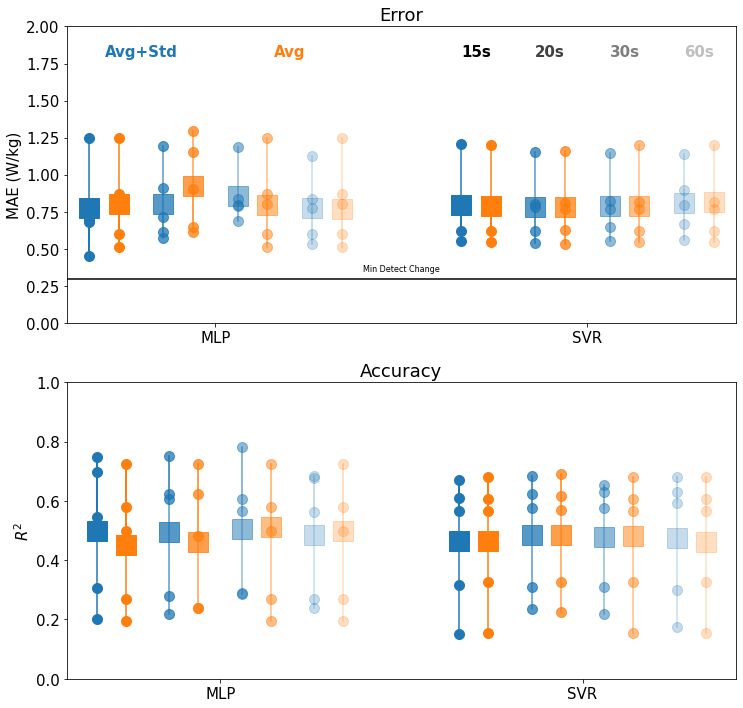

In [66]:
# error and accuracy plot
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 15})
labels = Avg8.keys()
width = 0.15
MS = 10
x = np.arange(len(labels))
A = np.ones((len(Avg8.keys()), kf.n_splits))
A[1,:] = 2
FS = 15
a1 = 1
a2 = 0.75
a3 = 0.5
a4 = 0.25
LW = 3
cap = 4
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
w1 = -0.34
w2 = -0.14
w3 = 0.06
w4 = 0.26
w1b = -0.26
w2b = -0.06
w3b = 0.14
w4b = 0.34

mkr = 'o'
ax1.hlines(0.3, 0.6, 2.4)

# plot MLP errors
x = np.ones((len(MAE8['MLPAvg']), 1))
ax1.plot(np.add(x, w1), MAE8['MLPAvgStd'], marker=mkr, color='C0', ms=MS, alpha=a1)
ax1.plot(np.add(x, w2), MAE6['MLPAvgStd'], marker=mkr, color='C0', ms=MS, alpha=a2)
ax1.plot(np.add(x, w3), MAE4['MLPAvgStd'], marker=mkr, color='C0', ms=MS, alpha=a3)
ax1.plot(np.add(x, w4), MAE2['MLPAvgStd'], marker=mkr, color='C0', ms=MS, alpha=a4)
ax1.plot(np.add(x, w1b), MAE8['MLPAvg'], marker=mkr, color='C1', ms=MS, alpha=a1)
ax1.plot(np.add(x, w2b), MAE6['MLPAvg'], marker=mkr, color='C1', ms=MS, alpha=a2)
ax1.plot(np.add(x, w3b), MAE8['MLPAvg'], marker=mkr, color='C1', ms=MS, alpha=a3)
ax1.plot(np.add(x, w4b), MAE8['MLPAvg'], marker=mkr, color='C1', ms=MS, alpha=a4)

ax1.plot(1+w1, np.mean(MAE8['MLPAvgStd']), 's', color='C0', ms=MS*2, alpha=a1)
ax1.plot(1+w2, np.mean(MAE6['MLPAvgStd']), 's', color='C0', ms=MS*2, alpha=a2)
ax1.plot(1+w3, np.mean(MAE4['MLPAvgStd']), 's', color='C0', ms=MS*2, alpha=a3)
ax1.plot(1+w4, np.mean(MAE2['MLPAvgStd']), 's', color='C0', ms=MS*2, alpha=a4)
ax1.plot(1+w1b, np.mean(MAE8['MLPAvg']), 's', color='C1', ms=MS*2, alpha=a1)
ax1.plot(1+w2b, np.mean(MAE6['MLPAvg']), 's', color='C1', ms=MS*2, alpha=a2)
ax1.plot(1+w3b, np.mean(MAE4['MLPAvg']), 's', color='C1', ms=MS*2, alpha=a3)
ax1.plot(1+w4b, np.mean(MAE2['MLPAvg']), 's', color='C1', ms=MS*2, alpha=a4)

# svr errors
x = np.multiply(np.ones((len(MAE8['MLPAvg']), 1)), 2)
ax1.plot(np.add(x, w1), MAE8['SVRAvgStd'], marker=mkr, color='C0', ms=MS, alpha=a1)
ax1.plot(np.add(x, w2), MAE6['SVRAvgStd'], marker=mkr, color='C0', ms=MS, alpha=a2)
ax1.plot(np.add(x, w3), MAE4['SVRAvgStd'], marker=mkr, color='C0', ms=MS, alpha=a3)
ax1.plot(np.add(x, w4), MAE2['SVRAvgStd'], marker=mkr, color='C0', ms=MS, alpha=a4)
ax1.plot(np.add(x, w1b), MAE8['SVRAvg'], marker=mkr, color='C1', ms=MS, alpha=a1)
ax1.plot(np.add(x, w2b), MAE6['SVRAvg'], marker=mkr, color='C1', ms=MS, alpha=a2)
ax1.plot(np.add(x, w3b), MAE8['SVRAvg'], marker=mkr, color='C1', ms=MS, alpha=a3)
ax1.plot(np.add(x, w4b), MAE8['SVRAvg'], marker=mkr, color='C1', ms=MS, alpha=a4)
X = 2
h1 = ax1.plot(X+w1, np.mean(MAE8['SVRAvgStd']), 's', color='C0', ms=MS*2, alpha=a1)
ax1.plot(X+w2, np.mean(MAE6['SVRAvgStd']), 's', color='C0', ms=MS*2, alpha=a2)
ax1.plot(X+w3, np.mean(MAE4['SVRAvgStd']), 's', color='C0', ms=MS*2, alpha=a3)
ax1.plot(X+w4, np.mean(MAE2['SVRAvgStd']), 's', color='C0', ms=MS*2, alpha=a4)
h2 = ax1.plot(X+w1b, np.mean(MAE8['SVRAvg']), 's', color='C1', ms=MS*2, alpha=a1)
ax1.plot(X+w2b, np.mean(MAE6['SVRAvg']), 's', color='C1', ms=MS*2, alpha=a2)
ax1.plot(X+w3b, np.mean(MAE4['SVRAvg']), 's', color='C1', ms=MS*2, alpha=a3)
ax1.plot(X+w4b, np.mean(MAE2['SVRAvg']), 's', color='C1', ms=MS*2, alpha=a4)

ax1.set_ylabel('MAE (W/kg)')
ax1.set_xticks([1,2])
ax1.set_xticklabels(labels)
ax1.set_title('Error')
ax1.text(1.5, 0.35, 'Min Detect Change', fontsize=8, ha='center')
ax1.set_ylim((0, 2))
ax1.set_xlim((0.6, 2.4))
ax1.text(0.8, 1.8, 'Avg+Std', color='C0', fontsize=FS, weight='bold', ha='center')
ax1.text(1.2, 1.8, 'Avg', color='C1', fontsize=FS, weight='bold', ha='center')
ax1.text(1.7, 1.8, '15s', color='k', fontsize=FS, weight='bold', ha='center', alpha=a1)
ax1.text(1.9, 1.8, '20s', color='k', fontsize=FS, weight='bold', ha='center', alpha=a2)
ax1.text(2.1, 1.8, '30s', color='k', fontsize=FS, weight='bold', ha='center', alpha=a3)
ax1.text(2.3, 1.8, '60s', color='k', fontsize=FS, weight='bold', ha='center', alpha=a4)

# plot correlation values
# plot MLP corr
x = np.ones((len(Avg8['MLP']), 1))
ax2.plot(np.add(x, w1), AvgStd8['MLP'], marker=mkr, color='C0', ms=MS, alpha=a1)
ax2.plot(np.add(x, w2), AvgStd6['MLP'], marker=mkr, color='C0', ms=MS, alpha=a2)
ax2.plot(np.add(x, w3), AvgStd4['MLP'], marker=mkr, color='C0', ms=MS, alpha=a3)
ax2.plot(np.add(x, w4), AvgStd2['MLP'], marker=mkr, color='C0', ms=MS, alpha=a4)
ax2.plot(np.add(x, w1b), Avg8['MLP'], marker=mkr, color='C1', ms=MS, alpha=a1)
ax2.plot(np.add(x, w2b), Avg6['MLP'], marker=mkr, color='C1', ms=MS, alpha=a2)
ax2.plot(np.add(x, w3b), Avg8['MLP'], marker=mkr, color='C1', ms=MS, alpha=a3)
ax2.plot(np.add(x, w4b), Avg8['MLP'], marker=mkr, color='C1', ms=MS, alpha=a4)

ax2.plot(1+w1, np.mean(AvgStd8['MLP']), 's', color='C0', ms=MS*2, alpha=a1)
ax2.plot(1+w2, np.mean(AvgStd6['MLP']), 's', color='C0', ms=MS*2, alpha=a2)
ax2.plot(1+w3, np.mean(AvgStd4['MLP']), 's', color='C0', ms=MS*2, alpha=a3)
ax2.plot(1+w4, np.mean(AvgStd2['MLP']), 's', color='C0', ms=MS*2, alpha=a4)
ax2.plot(1+w1b, np.mean(Avg8['MLP']), 's', color='C1', ms=MS*2, alpha=a1)
ax2.plot(1+w2b, np.mean(Avg6['MLP']), 's', color='C1', ms=MS*2, alpha=a2)
ax2.plot(1+w3b, np.mean(Avg4['MLP']), 's', color='C1', ms=MS*2, alpha=a3)
ax2.plot(1+w4b, np.mean(Avg2['MLP']), 's', color='C1', ms=MS*2, alpha=a4)

# svr corr
x = np.multiply(np.ones((len(AvgStd8['MLP']), 1)), 2)
ax2.plot(np.add(x, w1), AvgStd8['SVR'], marker=mkr, color='C0', ms=MS, alpha=a1)
ax2.plot(np.add(x, w2), AvgStd6['SVR'], marker=mkr, color='C0', ms=MS, alpha=a2)
ax2.plot(np.add(x, w3), AvgStd4['SVR'], marker=mkr, color='C0', ms=MS, alpha=a3)
ax2.plot(np.add(x, w4), AvgStd2['SVR'], marker=mkr, color='C0', ms=MS, alpha=a4)
ax2.plot(np.add(x, w1b), Avg8['SVR'], marker=mkr, color='C1', ms=MS, alpha=a1)
ax2.plot(np.add(x, w2b), Avg6['SVR'], marker=mkr, color='C1', ms=MS, alpha=a2)
ax2.plot(np.add(x, w3b), Avg8['SVR'], marker=mkr, color='C1', ms=MS, alpha=a3)
ax2.plot(np.add(x, w4b), Avg8['SVR'], marker=mkr, color='C1', ms=MS, alpha=a4)
X = 2
t1 = ax2.plot(X+w1, np.mean(AvgStd8['SVR']), 's', color='C0', ms=MS*2, alpha=a1)
t2 = ax2.plot(X+w2, np.mean(AvgStd6['SVR']), 's', color='C0', ms=MS*2, alpha=a2)
t3 = ax2.plot(X+w3, np.mean(AvgStd4['SVR']), 's', color='C0', ms=MS*2, alpha=a3)
t4 = ax2.plot(X+w4, np.mean(AvgStd2['SVR']), 's', color='C0', ms=MS*2, alpha=a4)
ax2.plot(X+w1b, np.mean(AvgStd8['SVR']), 's', color='C1', ms=MS*2, alpha=a1)
ax2.plot(X+w2b, np.mean(Avg6['SVR']), 's', color='C1', ms=MS*2, alpha=a2)
ax2.plot(X+w3b, np.mean(Avg4['SVR']), 's', color='C1', ms=MS*2, alpha=a3)
ax2.plot(X+w4b, np.mean(Avg2['SVR']), 's', color='C1', ms=MS*2, alpha=a4)


ax2.set_ylabel('$R^2$')
ax2.set_ylim([0, 1])
ax2.set_xticks([1,2])
ax2.set_xticklabels(labels)
ax2.set_title('Accuracy')

# ax2.set_legend([t1,t2,t3,t4],['15s','20s','30s','60s'])

plt.savefig('Figures/ErrAcc.png')

In [ ]:

# # Scatter plots
# plt.plot([0, 9], [0, 9], '--k')
# MLP6 = {}
# for j, (train_index, test_index) in enumerate(kf.split(SubjInds)):
#   # split into training and testing set - subject leave out
#   TrainInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[train_index]]
#   TestInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[test_index]]

#   X_train = AugAvg.iloc[TrainInds,7:]
#   X_test = AugAvg.iloc[TestInds,7:]
#   y_train = AugAvg.iloc[TrainInds,5]
#   y_test = AugAvg.iloc[TestInds,5]

#   Pred = mlp.predict(X_test)
#   MLP6[j] = pearsonr(y_test, Pred)[0]**2
#   # print('MLP R^2:', MLP6[j])
#   p = np.polyfit(y_test, Pred, 1)
#   newX = np.linspace(min(y_test), max(y_test))
#   newY = np.polyval(p, newX)
#   ax3.plot(newX, newY, '-', color='C' + str(j), lw=LW, label=j+1)

#   mlp = joblib.load('Models/MLP_Avg_6_' + str(j)) # load MLP model
#   ax3.scatter(y_test, mlp.predict(X_test), alpha=al)
#   ax3.set_xlabel('Measured (W/kg)')
#   ax3.set_ylabel('Estimated (W/kg)')
#   ax3.set_title('MLP Avg')
#   ax3.legend(title='K Fold', fontsize=10)

# plt.savefig('Figures/Bin6.png')

# analyze the effect of keypoint fidelity

In [ ]:
# Implement Avg + Std dataset
AugAvgStd = pd.concat([MetaDF.reset_index(), AvgDF8.reset_index(drop=True)], axis=1, ignore_index=True)
AugAvgStd = AugAvgStd.dropna()

kf = KFold(n_splits=5)
SubjInds = np.arange(1,21)
AvgStd8['MLP'] = []
AvgStd8['SVR'] = []
MAE8['MLPAvgStd'] = []
MAEstd8['MLPAvgStd'] = []
MAE8['SVRAvgStd'] = []
MAEstd8['SVRAvgStd'] = []
for j, (train_index, test_index) in enumerate(kf.split(SubjInds)):
  print(f"Fold {j}:")

  # split into training and testing set - subject leave out
  TrainInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[train_index]]
  TestInds = [i for i,x in enumerate(AugAvgStd.iloc[:,2]) if x in SubjInds[test_index]]
  X_train = AugAvgStd.iloc[TrainInds,7:]
  X_test = AugAvgStd.iloc[TestInds,7:]
  y_train = AugAvgStd.iloc[TrainInds,5]
  y_test = AugAvgStd.iloc[TestInds,5]

  if ReTrain == 1:
    # SVR
    svr = SVR(kernel='poly', degree=6)
    svr.fit(X_train, y_train)
    joblib.dump(svr, 'Models/SVR_AvgStd_8_' + str(j), compress=0) # save model
    AvgStd8['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    MAE8['SVRAvgStd'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd8['SVRAvgStd'].append(np.std(abs(svr.predict(X_test) - y_test)))
    
    # multilayer perceptron
    mlp = MLPRegressor(hidden_layer_sizes=[100, 10]) # 
    mlp.fit(X_train, y_train)
    joblib.dump(mlp, 'Models/MLP_AvgStd_8_' + str(j), compress=0) # save model
    AvgStd8['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE8['MLPAvgStd'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd8['MLPAvgStd'].append(np.std(abs(mlp.predict(X_test) - y_test)))
    
  else: # load pre-trained models
    svr = joblib.load('Models/SVR_AvgStd_8_' + str(j)) # load SVR model
    AvgStd8['SVR'].append(pearsonr(svr.predict(X_test), y_test)[0]**2)
    MAE8['SVRAvgStd'].append(np.mean(abs(svr.predict(X_test) - y_test)))
    MAEstd8['SVRAvgStd'].append(np.std(abs(svr.predict(X_test) - y_test)))

    mlp = joblib.load('Models/MLP_AvgStd_8_' + str(j)) # load MLP model
    AvgStd8['MLP'].append(pearsonr(mlp.predict(X_test), y_test)[0]**2)
    MAE8['MLPAvgStd'].append(np.mean(abs(mlp.predict(X_test) - y_test)))
    MAEstd8['MLPAvgStd'].append(np.std(abs(mlp.predict(X_test) - y_test)))

  print('SVR Score:', round(AvgStd8['SVR'][j], 3))
  print('MLP Score:', round(AvgStd8['MLP'][j], 3))
  print(' ')

In [67]:
os.chdir('/content/drive/My Drive/SpeedFpClampData')
DF_Full = pd.read_csv('MetCostTRCData_8.csv') # load full 8 dataset
# DF_Torso = pd.read_csv('MetCostTRCData_torso_8.csv')
# DF_Foot = pd.read_csv('MetCostTRCData_foot_8.csv')
# DF_Base = pd.read_csv('MetCostTRCData_base_8.csv')
# DF_Sham = pd.read_csv('MetCostTRCData_sham_8.csv')

In [71]:
from matplotlib import cm
cmap = cm.rainbow(np.linspace(0, 1, 20))
plt.style = 'seaborn'

In [149]:
AugAvgStd

,Subj,Cond,Bin,MetCost,RSHOx_Avg,RSHOx_Avg.1,RSHOx_Avg.2,RSHOx_Avg.3,RSHOx_Avg.4,RSHOx_Avg.5,...,LWRIz_Std.90,LWRIz_Std.91,LWRIz_Std.92,LWRIz_Std.93,LWRIz_Std.94,LWRIz_Std.95,LWRIz_Std.96,LWRIz_Std.97,LWRIz_Std.98,LWRIz_Std.99
0,14,C_M20,0,5.712335,0.334111,1.494358,-0.978549,0.330945,0.372804,-0.326993,...,0.059081,0.100677,0.004084,0.047796,0.096458,0.000487,0.053522,0.109406,0.035411,0.102465
1,14,C_M20,1,5.195330,0.381565,1.490449,-1.060373,0.376343,0.365749,-0.418001,...,0.065349,0.060586,0.008593,0.054416,0.058973,0.000525,0.052800,0.077986,0.023608,0.073472
2,14,C_M20,2,5.494525,0.701213,1.485661,-1.225783,0.642973,0.369406,-0.568108,...,0.105004,0.107866,0.006040,0.122565,0.106174,0.000654,0.108560,0.089648,0.028829,0.140165
3,14,C_M20,3,5.067709,0.420034,1.480033,-1.125231,0.350636,0.369223,-0.466355,...,0.068186,0.178169,0.007986,0.073384,0.180424,0.000383,0.064408,0.272430,0.026619,0.034539
4,14,C_M20,4,5.337077,-0.349369,1.490597,-1.022708,-0.387193,0.370451,-0.381906,...,0.084271,0.116468,0.002163,0.094192,0.129429,0.000383,0.104091,0.136580,0.024193,0.095759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,2,S_P20,3,6.751697,0.380047,1.490684,-1.158443,0.746059,-0.363994,0.403343,...,0.054052,0.077782,0.004703,0.037890,0.093005,0.000677,0.036889,0.107015,0.039280,0.071674
3836,2,S_P20,4,6.512136,0.119983,1.488730,-1.163075,0.426640,-0.362212,0.400129,...,0.047004,0.113171,0.007220,0.043882,0.100693,0.000647,0.041963,0.127159,0.032894,0.101781
3837,2,S_P20,5,6.650040,-0.013566,1.490423,-1.127836,0.292876,-0.365486,0.377145,...,0.052527,0.127469,0.005863,0.037584,0.118195,0.000517,0.048805,0.147871,0.024484,0.086033
3838,2,S_P20,6,6.678278,-0.567278,1.479821,-1.049815,-0.263971,-0.363454,0.300377,...,0.060276,0.269194,0.007777,0.054319,0.276248,0.000933,0.067808,0.239592,0.025317,0.085905


In [ ]:
MetaDF = pd.concat([DF_Full.iloc[:,0:5], DF_Full.iloc[:,0:5]], axis=0)
AugAvgStd = pd.concat([MetaDF.reset_index(), AvgDF8.reset_index(drop=True)], axis=1, ignore_index=True)
AugAvgStd = AugAvgStd.dropna()
AugAvgStd = AugAvgStd.drop(labels=[0,1,6], axis=1)
AugAvgStd.columns = ['Subj','Cond','Bin', 'MetCost'] + list(AvgDF8.columns)[1:]

In [153]:
D

,Subj,Cond,Bin,MetCost,RSHOx_Avg,RSHOx_Avg.1,RSHOx_Avg.2,RSHOx_Avg.3,RSHOx_Avg.4,RSHOx_Avg.5,...,LWRIz_Std.90,LWRIz_Std.91,LWRIz_Std.92,LWRIz_Std.93,LWRIz_Std.94,LWRIz_Std.95,LWRIz_Std.96,LWRIz_Std.97,LWRIz_Std.98,LWRIz_Std.99
0,14,C_M20,0,5.712335,0.334111,1.494358,-0.978549,0.330945,0.372804,-0.326993,...,0.059081,0.100677,0.004084,0.047796,0.096458,0.000487,0.053522,0.109406,0.035411,0.102465
1,14,C_M20,1,5.195330,0.381565,1.490449,-1.060373,0.376343,0.365749,-0.418001,...,0.065349,0.060586,0.008593,0.054416,0.058973,0.000525,0.052800,0.077986,0.023608,0.073472
2,14,C_M20,2,5.494525,0.701213,1.485661,-1.225783,0.642973,0.369406,-0.568108,...,0.105004,0.107866,0.006040,0.122565,0.106174,0.000654,0.108560,0.089648,0.028829,0.140165
3,14,C_M20,3,5.067709,0.420034,1.480033,-1.125231,0.350636,0.369223,-0.466355,...,0.068186,0.178169,0.007986,0.073384,0.180424,0.000383,0.064408,0.272430,0.026619,0.034539
4,14,C_M20,4,5.337077,-0.349369,1.490597,-1.022708,-0.387193,0.370451,-0.381906,...,0.084271,0.116468,0.002163,0.094192,0.129429,0.000383,0.104091,0.136580,0.024193,0.095759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,2,S_P20,3,6.751697,0.380047,1.490684,-1.158443,0.746059,-0.363994,0.403343,...,0.054052,0.077782,0.004703,0.037890,0.093005,0.000677,0.036889,0.107015,0.039280,0.071674
3836,2,S_P20,4,6.512136,0.119983,1.488730,-1.163075,0.426640,-0.362212,0.400129,...,0.047004,0.113171,0.007220,0.043882,0.100693,0.000647,0.041963,0.127159,0.032894,0.101781
3837,2,S_P20,5,6.650040,-0.013566,1.490423,-1.127836,0.292876,-0.365486,0.377145,...,0.052527,0.127469,0.005863,0.037584,0.118195,0.000517,0.048805,0.147871,0.024484,0.086033
3838,2,S_P20,6,6.678278,-0.567278,1.479821,-1.049815,-0.263971,-0.363454,0.300377,...,0.060276,0.269194,0.007777,0.054319,0.276248,0.000933,0.067808,0.239592,0.025317,0.085905


Fitting SVR Model


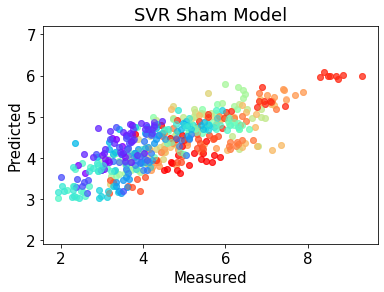

Model: Sham
Support Vector Regression Results
MAE = 0.7851
Training Time = 28.86940336227417
R^2 = 0.6283
Fitting MLP Model


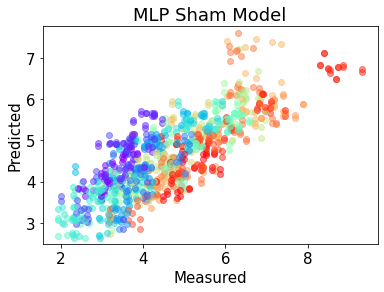

Model: Sham
MLP Results
MAE = 0.6798
Training Time = 51.676456451416016
R^2 = 0.6548
 
Fitting SVR Model


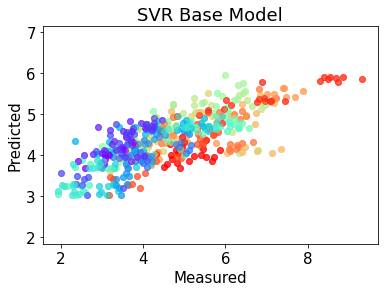

Model: Base
Support Vector Regression Results
MAE = 0.7964
Training Time = 28.452594995498657
R^2 = 0.6001
Fitting MLP Model


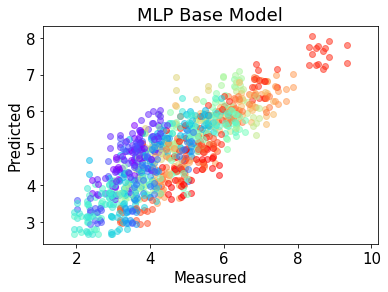

Model: Base
MLP Results
MAE = 0.662
Training Time = 59.84181499481201
R^2 = 0.7001
 
Fitting SVR Model


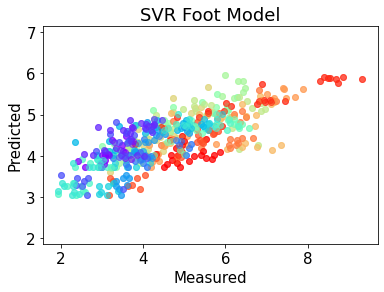

Model: Foot
Support Vector Regression Results
MAE = 0.794
Training Time = 38.5520544052124
R^2 = 0.6042
Fitting MLP Model


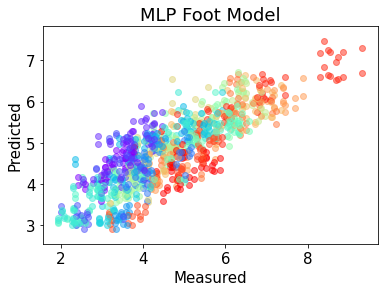

Model: Foot
MLP Results
MAE = 0.6592
Training Time = 38.18127083778381
R^2 = 0.6974
 
Fitting SVR Model


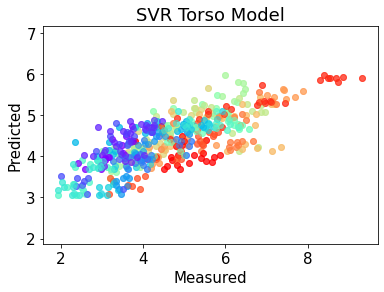

Model: Torso
Support Vector Regression Results
MAE = 0.7932
Training Time = 44.826152086257935
R^2 = 0.6055
Fitting MLP Model


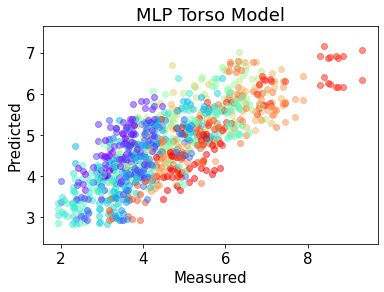

Model: Torso
MLP Results
MAE = 0.7235
Training Time = 68.45787239074707
R^2 = 0.6079
 
Fitting SVR Model


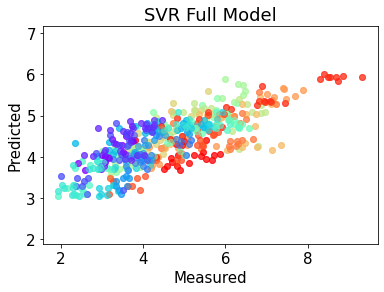

Model: Full
Support Vector Regression Results
MAE = 0.787
Training Time = 64.51132225990295
R^2 = 0.6184
Fitting MLP Model


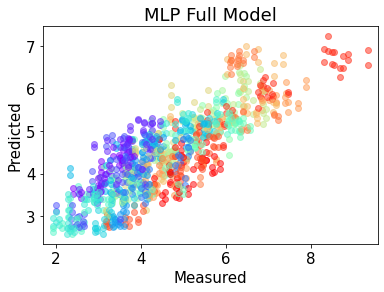

Model: Full
MLP Results
MAE = 0.6479
Training Time = 108.85179162025452
R^2 = 0.7008
 


In [154]:
from sklearn import svm
SVR = {}
MLP = {}
models = ['Sham','Base','Foot','Torso','Full']
DIM = 15*50 # reshape dimension

MetaDF = pd.concat([DF_Full.iloc[:,0:5], DF_Full.iloc[:,0:5]], axis=0)
AugAvgStd = pd.concat([MetaDF.reset_index(), AvgDF8.reset_index(drop=True)], axis=1, ignore_index=True)
AugAvgStd = AugAvgStd.dropna()
AugAvgStd = AugAvgStd.drop(labels=[0,1,6], axis=1)
AugAvgStd.columns = ['Subj','Cond','Bin', 'MetCost'] + list(AvgDF8.columns)[1:]

for model in models:
    if model == 'Full':
        D = AugAvgStd
    elif model == 'Torso':
        ToDelList = ['WRI', 'ELB']
        ToDel = []
        for i,x in enumerate(AugAvgStd.columns):
            for L in ToDelList:
                if L in x:
                    ToDel.append(x)
        D = AugAvgStd.drop(labels=ToDel, axis=1)
    elif model == 'Foot':
        ToDelList = ['WRI', 'ELB','SHO']
        ToDel = []
        for i,x in enumerate(AugAvgStd.columns):
            for L in ToDelList:
                if L in x:
                    ToDel.append(x)
        D = AugAvgStd.drop(labels=ToDel, axis=1)
    elif model == 'Base':
        ToDelList = ['WRI', 'ELB','SHO','TOE']
        ToDel = []
        for i,x in enumerate(AugAvgStd.columns):
            for L in ToDelList:
                if L in x:
                    ToDel.append(x)
        D = AugAvgStd.drop(labels=ToDel, axis=1)
    elif model == 'Sham':
        ToDelList = ['TOE', 'KNEE','HIP','ANK']
        ToDel = []
        for i,x in enumerate(AugAvgStd.columns):
            for L in ToDelList:
                if L in x:
                    ToDel.append(x)
        D = AugAvgStd.drop(labels=ToDel, axis=1)

    S = []
    subj = D.query('Bin > 5')['Subj'].to_list() 
    for s in subj:
        S.append(int(float(s)))

    # LeaveOut = 'Obs'
    LeaveOut = 'Subj'
    if LeaveOut == 'Obs':
        X_train = D.query('Bin < 6').iloc[:,4:]
        Y_train = D.query('Bin < 6').iloc[:,3]
        X_test = D.query('Bin > 5').iloc[:,4:]
        Y_test = D.query('Bin > 5').iloc[:,4]
    elif LeaveOut == 'Subj':
        X_train = D.query('Subj < 16').iloc[:,4:]
        Y_train = D.query('Subj < 16').iloc[:,3]
        X_test = D.query('Subj > 15').iloc[:,4:]
        Y_test = D.query('Subj > 15').iloc[:,3]

    # SVR
    SVR[model] = {}
    clf = svm.SVR(kernel="poly", degree=6)
    # Fit SVR model
    start = time.time()
    print('Fitting SVR Model')
    clf.fit(X_train,Y_train)
    # predict
    SVR_P = clf.predict(X_test)
    finish = time.time()
    SVR[model]['Model'] = clf

    # plot prediction results
    for i in range(len(Y_test)):
        plt.plot(Y_test.tolist()[i], SVR_P[i],'o', c=cmap[S[i]-1], alpha=0.5)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.axis('equal')
    plt.title('SVR ' + model + ' Model')
    plt.show()

    d = Y_test - SVR_P
    e = ~(np.isnan(Y_test))
    SVR_results = stats.linregress(Y_test[e], 
                    SVR_P[e])

    print('Model: ' + model)
    print('Support Vector Regression Results')
    print('MAE = ' + str(round(np.mean(np.abs(d)),4)))
    print('Training Time = ' + str(finish-start))
    print('R^2 = ' + str(round(SVR_results.rvalue**2, 4)))
    
    SVR[model]['Training Time'] = finish-start
    SVR[model]['MAE'] = round(np.mean(np.abs(d)),4)
    SVR[model]['R^2'] = round(SVR_results.rvalue**2, 4)
    SVR[model]['Prediction'] = SVR_P[e].tolist()
    SVR[model]['True'] = Y_test[e].tolist()

    # MLP Model
    MLP[model] = {}
    clf = MLPRegressor(hidden_layer_sizes=[100, 10])
    # Fit SVR model
    start = time.time()
    print('Fitting MLP Model')
    clf.fit(X_train,Y_train)
    # predict
    MLP_P = clf.predict(X_test)
    finish = time.time()
    MLP[model]['Model'] = clf

    # plot prediction results
    for i in range(len(Y_test)):
        plt.plot(Y_test.tolist()[i], MLP_P[i],'o', c=cmap[S[i]-1], alpha=0.5)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.axis('equal')
    plt.title('MLP ' + model + ' Model')
    plt.show()

    d = Y_test - MLP_P
    e = ~(np.isnan(Y_test))
    MLP_results = stats.linregress(Y_test[e], 
                    MLP_P[e])

    print('Model: ' + model)
    print('MLP Results')
    print('MAE = ' + str(round(np.mean(np.abs(d)),4)))
    print('Training Time = ' + str(finish-start))
    print('R^2 = ' + str(round(MLP_results.rvalue**2, 4)))

    print(' ')

    MLP[model]['Training Time'] = finish-start
    MLP[model]['MAE'] = round(np.mean(np.abs(d)),4)
    MLP[model]['R^2'] = round(MLP_results.rvalue**2, 4)
    MLP[model]['Prediction'] = MLP_P[e].tolist()
    MLP[model]['True'] = Y_test[e].tolist()


In [ ]:
Aug

In [ ]:
AvgDF8

In [ ]:
# test out SVR hyperparameters

# # Fit regression model
# x_train = X_train.to_numpy()
# y_train = Y_train.to_numpy()
# x_test = X_test.to_numpy()
# y_test = Y_test.to_numpy()

# # svr_rbf = svm.SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
# # svr_lin = svm.SVR(kernel="linear", C=100, gamma="auto")
# # svr_poly = svm.SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
# svr_poly1 = svm.SVR(kernel="poly", C=100, gamma="auto", degree=6, epsilon=0.1, coef0=0.5)
# svr_poly2 = svm.SVR(kernel="poly", C=100, gamma="auto", degree=6, epsilon=0.1, coef0=1)
# svr_poly3 = svm.SVR(kernel="poly", C=100, gamma="auto", degree=6, epsilon=0.1, coef0=2)

# # Look at the results
# lw = 2

# # svrs = [svr_rbf, svr_lin, svr_poly]
# svrs = [svr_poly1, svr_poly2, svr_poly3]
# # kernel_label = ["RBF", "Linear", "Polynomial"]
# kernel_label = ["Poly1", "Poly2", "Poly3"]
# model_color = ["m", "c", "g"]

# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), sharey=True)
# for ix, svr in enumerate(svrs):# Defining and training an SVR Model
#     mdl = svr.fit(x_train, y_train)
#     P = mdl.predict(x_test)
#     axes[ix].plot(
#         y_test,
#         P ,
#         'o',
#         ms = 8,
#         color=model_color[ix],
#         lw=lw,
#         label="{} model".format(kernel_label[ix]),
#         )
#     e = ~(np.isnan(Y_test))
#     c = ccc(y_test[e], P[e])
#     print(svr)
#     print('CCC = ' + str(round(c, 4)))
#     axes[ix].axis('equal')
#     # axes[ix].scatter(
#     #     x_test[svr.support_],
#     #     y_test[svr.support_],
#     #     facecolor="none",
#     #     edgecolor=model_color[ix],
#     #     s=50,
#     #     label="{} support vectors".format(kernel_label[ix]),
#     #     )

# Plot Results

In [ ]:
plt.rcParams.update({'font.size': 18})
import seaborn as sns
fig = plt.figure(figsize=(30, 8))
ax0 = plt.subplot(141)
ax1 = plt.subplot(142)
ax2 = plt.subplot(143)
ax3 = plt.subplot(144)

# ax1.plot(w, w, '--k')
A1 = 0.25
A2 = 0.8
lw=4
lw2 = 3
cmap = cm.cool(np.linspace(0, 1, 5))
w = np.linspace(0, 10, num=11)
ax3.plot(w, w, '--k', lw=lw, label='Exact Fit: 1.0')

# figure of the markers
TRC = DF_Full.iloc[i,5:]
d = len(TRC) / 750
A = np.reshape(TRC.to_list(), (750, int(d)), order='F')
a = A[0,:]
x = list(range(0, int(d), 3))
y = list(range(1, int(d), 3))
z = list(range(2, int(d), 3))

# Draw stick figure
# left side
ax0.plot([ a[z[0]], a[z[1]] ], [ a[y[0]], a[y[1]] ], 'k', lw=lw2)
ax0.plot([ a[z[0]], a[z[3]] ], [ a[y[0]], a[y[3]] ], 'k', lw=lw2)
ax0.plot([ a[z[1]], a[z[4]] ], [ a[y[1]], a[y[4]] ], 'k', lw=lw2)
ax0.plot([ a[z[6]], a[z[3]] ], [ a[y[6]], a[y[3]] ], 'k', lw=lw2)
ax0.plot([ a[z[2]], a[z[4]] ], [ a[y[2]], a[y[4]] ], 'k', lw=lw2)
ax0.plot([ a[z[2]], a[z[5]] ], [ a[y[2]], a[y[5]] ], 'k', lw=lw2)
# right side
ax0.plot([ a[z[7]], a[z[8]] ], [ a[y[7]], a[y[8]] ], 'k', lw=lw2)
ax0.plot([ a[z[7]], a[z[10]] ], [ a[y[7]], a[y[10]] ], 'k', lw=lw2)
ax0.plot([ a[z[8]], a[z[11]] ], [ a[y[8]], a[y[11]] ], 'k', lw=lw2)
ax0.plot([ a[z[10]], a[z[13]] ], [ a[y[10]], a[y[13]] ], 'k', lw=lw2)
ax0.plot([ a[z[9]], a[z[12]] ], [ a[y[9]], a[y[12]] ], 'k', lw=lw2)
ax0.plot([ a[z[9]], a[z[11]] ], [ a[y[9]], a[y[11]] ], 'k', lw=lw2)
# connect L and R sides
ax0.plot([ a[z[7]], a[z[0]] ], [ a[y[7]], a[y[0]] ], 'k', lw=lw2)
ax0.plot([ a[z[1]], a[z[8]] ], [ a[y[1]], a[y[8]] ], 'k', lw=lw2)

# plot keypoint sets
# base
for k in [1,2,4,8,9,11]: 
    ax0.plot(a[z[k]], a[y[k]], color=cmap[1,:], marker='s', ms=15) 
# plot full keypoint set
ax0.plot(a[z], a[y], mfc=cmap[4,:], marker='o', lw=0, ms=8, 
         mec='k', mew=2)

ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.axis('equal')
ax0.set_title('A: Keypoint Sets')
ax0.set_xticks([])
ax0.set_yticks([])
# ax0.set_xlim([-2.3, 0.5])
F = 16
xloc = -0.8
ax0.text(xloc, 1.6, 'Full', weight='bold', color=cmap[4,:])
ax0.text(xloc, 1.5, 'Torso + Elbows &', color='k', fontsize=F)
ax0.text(xloc, 1.4, 'Wrists', color='k', fontsize=F)
ax0.text(xloc, 1.2, 'Torso', weight='bold', color=cmap[3,:])
ax0.text(xloc, 1.1, 'Foot + Shoulders', color='k', fontsize=F)
ax0.text(xloc, 0.9, 'Foot', weight='bold', color=cmap[2,:])
ax0.text(xloc, 0.8, 'Base + Toes', color='k', fontsize=F)
ax0.text(xloc, 0.6, 'Base', weight='bold', color=cmap[1,:])
ax0.text(xloc, 0.5, 'Hips, Knees, Ankles', color='k', fontsize=F)
ax0.text(xloc, 0.3, 'Sham', weight='bold', color=cmap[0,:])
ax0.text(xloc, 0.2, 'Shoulders, Elbows,', color='k', fontsize=F)
ax0.text(xloc, 0.1, '& Wrists', color='k', fontsize=F)

# results figures
for idx, m in enumerate(models): 
    # MAE
    ax1.plot(idx, MLP[m]['MAE'], 's', color=cmap[idx,:], ms=20, alpha=A2)
    ax1.plot(idx, SVR[m]['MAE'], 's', mec=cmap[idx,:], mfc='w', ms=20, mew=3, alpha=A2)
    
    # R^2
    ax2.plot(idx, MLP[m]['R^2'], 'o', color=cmap[idx,:], ms=20, alpha=A2)
    ax2.plot(idx, SVR[m]['R^2'], 'o', mec=cmap[idx,:], mfc='w', ms=20, mew=3, alpha=A2)

    # regression
    ax3.scatter(Y_test[e], MLP[m]['Prediction'],
                c=cmap[idx,:], alpha=A1)
    f = np.polyfit(Y_test[e], MLP[m]['Prediction'], 1)
    lbl = m + ': ' + str(f[0].round(2))
    ax3.plot(w, np.polyval(f, w), lw=lw, c=cmap[idx,:], alpha=A2, label=lbl)

    
ax1.set_title('B: Error')
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xticklabels(models)
ax1.set_ylabel('W/kg')
ax1.set_ylim([0, 1.5])
ax1.set_yticks([0, 0.5, 1, 1.5])
ax1.plot(0.1, 0.2, 's', color='k', ms=16)
ax1.plot(0.1, 0.4, 's', color='k', mfc='w', ms=16, mew=3)
ax1.text(0.25, 0.2, '= MLP', va='center', fontsize=F)
ax1.text(0.25, 0.4, '= SVR', va='center', fontsize=F)
ax1r = ax1.twinx()
ax1r.yaxis.tick_right()
ax1r.yaxis.set_label_position("right")
ax1r.set_ylabel("kcal/hr")
ax1r.set_ylim([0, 100])


ax2.set_title(r'C: Agreement')
ax2.set_xticks([0, 1, 2, 3, 4])
ax2.set_xticklabels(models)
ax2.set_ylabel('Coefficient')
ax2.plot(2.5, 0.95, 'o', color='k', ms=16)
ax2.plot(2.5, 0.85, 'o', color='k', mfc='w', ms=16, mew=3)
ax2.text(2.65, 0.95, '= MLP', va='center', fontsize=F)
ax2.text(2.65, 0.85, '= SVR', va='center', fontsize=F)
ax2.set_ylim([0.4, 1])

ax3.set_ylim((0, 10))
ax3.set_xlim((0, 10))
ax3.set_xlabel('Measured (W/kg)')
ax3.set_ylabel('Predicted (W/kg)')
ax3.set_title('D: Predictions & Regressions')
ax3.legend(fontsize=15)
ax3r = ax3.twinx()
ax3r.yaxis.tick_right()
ax3r.yaxis.set_label_position("right")
ax3r.set_ylabel("kcal/hr")
ax3r.set_ylim([0, 650])

fig.tight_layout(pad=2)
fig.savefig('MLOutput.png')
# fig.savefig('MLOutput.pdf')